<a href="https://colab.research.google.com/github/Kaptain15/test/blob/main/Forecasting_Sales_for_Inventory_Management_through_Regression_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model Building

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing import image
from sklearn.linear_model import LinearRegression

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

Create Train/Test Data Split

In [54]:
total_df.set_index(['date', 'store_nbr'], inplace=True)

In [55]:
train_data = total_df.loc[total_df.index.get_level_values('date') <= 1050]

In [56]:
test_data = total_df.loc[total_df.index.get_level_values('date') > 1050]

Creating Features/Target Variable

In [57]:
# Extracting features (all columns except 'sales') while preserving MultiIndex
train_features = train_data.drop(columns=['sales'])

# Extracting target variable (sales column) while preserving MultiIndex
train_sales = train_data[['sales']]

In [58]:
# Extracting features (all columns except 'sales') while preserving MultiIndex
test_features = test_data.drop(columns=['sales'])

# Extracting target variable (sales column) while preserving MultiIndex
test_sales = test_data[['sales']]

Linear Regression

In [ ]:
# Create the regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(train_features, train_sales)

# Predict sales using the trained model
train_sales_pred = model.predict(train_features)

In [ ]:
# Create a DataFrame with the predicted sales mapped back to train_data's index
train_data_total = pd.DataFrame(index=train_data.index)

# Add 'predicted_sales' as a new feature in train_data_total
train_data_total['predicted_sales'] = train_sales_pred

# Combine train_data and train_data_total
train_data_total = pd.concat([train_data, train_data_total], axis=1)

Linear Regression Train Data Prediction Performance

In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(train_data_total['sales'], train_data_total['predicted_sales'])

# Print MAE
print("Linear Regression Mean Absolute Error (MAE) on Train Data:", mae)

Linear Regression Mean Absolute Error (MAE) on Train Data: 2536.5929766165596


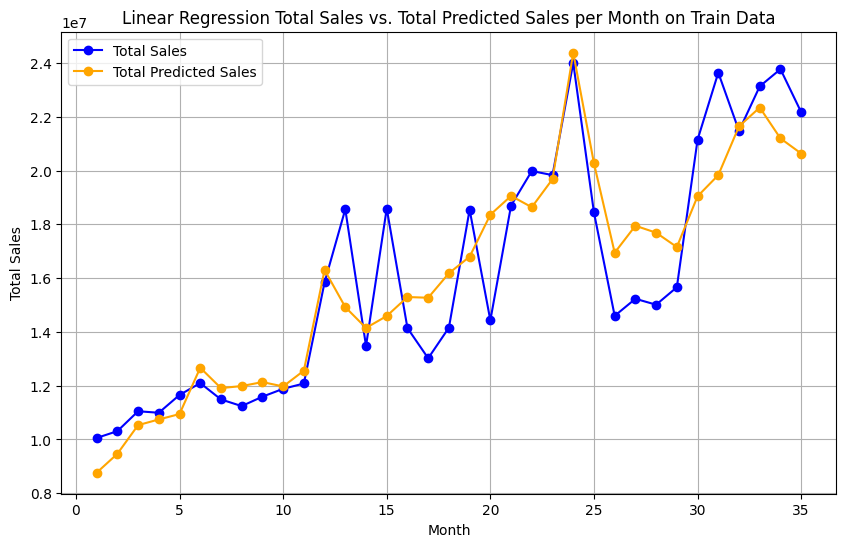

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Group train_data_total by date and store_nbr
grouped_data = train_data_total.groupby(['date', 'store_nbr']).sum()

# Determine the sales_month for each date
grouped_data['sales_month'] = (grouped_data.index.get_level_values(0) - 1) // 30 + 1

# Calculate total sales and total predicted sales per sales_month
total_sales_per_month = grouped_data.groupby('sales_month')['sales'].sum()
total_predicted_sales_per_month = grouped_data.groupby('sales_month')['predicted_sales'].sum()

# Plot total sales and total predicted sales per sales_month
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(total_sales_per_month, label='Total Sales', marker='o', color='blue')
plt.plot(total_predicted_sales_per_month, label='Total Predicted Sales', marker='o', color='orange')

plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Linear Regression Total Sales vs. Total Predicted Sales per Month on Train Data')
plt.legend()
plt.grid(True)
plt.show()

Linear Regression Performance on Testing Data

In [ ]:
# Predict sales using the trained model and test features
test_sales_pred = model.predict(test_features)

# Create a DataFrame with the predicted sales mapped back to test_features' index
test_data_total = pd.DataFrame(index=test_features.index)

# Add 'predicted_sales' as a new feature in test_data_total
test_data_total['predicted_sales'] = test_sales_pred

# Combine test_data and test_data_total
test_data_total = pd.concat([test_data, test_data_total], axis=1)

In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae_test = mean_absolute_error(test_data_total['sales'], test_data_total['predicted_sales'])

# Print MAE
print("Linear Regression Mean Absolute Error (MAE) on Test Data:", mae_test)

Linear Regression Mean Absolute Error (MAE) on Test Data: 9234.121743565838


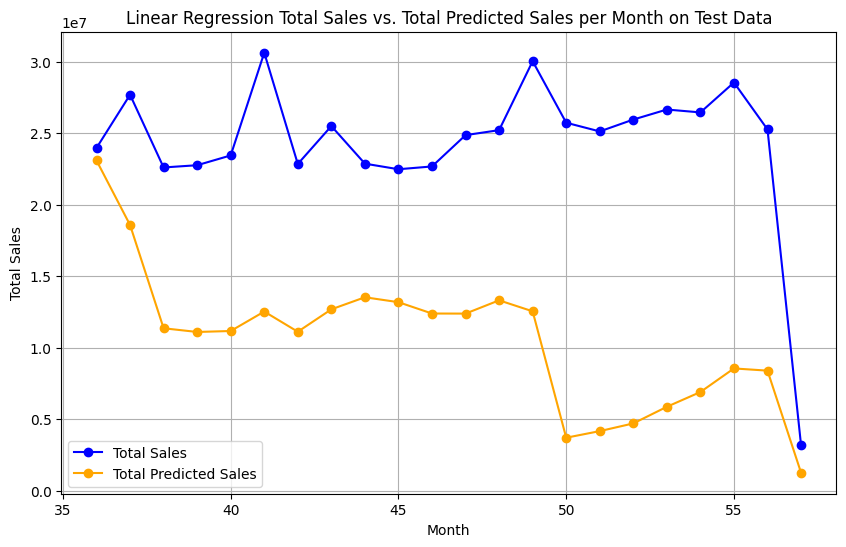

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Group train_data_total by date and store_nbr
grouped_data_test = test_data_total.groupby(['date', 'store_nbr']).sum()

# Determine the sales_month for each date
grouped_data_test['sales_month'] = (grouped_data_test.index.get_level_values(0) - 1) // 30 + 1

# Calculate total sales and total predicted sales per sales_month
total_sales_per_month_test = grouped_data_test.groupby('sales_month')['sales'].sum()
total_predicted_sales_per_month_test = grouped_data_test.groupby('sales_month')['predicted_sales'].sum()

# Plot total sales and total predicted sales per sales_month
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(total_sales_per_month_test, label='Total Sales', marker='o', color='blue')
plt.plot(total_predicted_sales_per_month_test, label='Total Predicted Sales', marker='o', color='orange')

plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Linear Regression Total Sales vs. Total Predicted Sales per Month on Test Data')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Load modules and data
import numpy as np

import statsmodels.api as sm

stats_data = sm.add_constant(train_features)

# Fit and summarize OLS model
mod = sm.OLS(train_sales, stats_data)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     5011.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:22:35   Log-Likelihood:            -4.8760e+05
No. Observations:               50172   AIC:                         9.753e+05
Df Residuals:                   50135   BIC:                         9.756e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


--------------------

Lasso Regression

In [59]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange
from sklearn.preprocessing import StandardScaler

# Scale the input features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)

# Define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define Lasso regression model with automatic alpha selection and L1 regularization
lasso_model = LassoCV(alphas=arange(0, 1, 0.01), cv=cv, n_jobs=-1, max_iter=10000, eps=1e-5)

# Fit the model to the training data
lasso_model.fit(train_features_scaled, train_sales)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You mi

LassoCV(alphas=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
        cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1), eps=1e-05,
        max_iter=10000, n_jobs=-1)

Lasso Performance Training Data

In [60]:
# Summarize chosen configuration
print('Optimal alpha for Lasso Regression:', lasso_model.alpha_)

Optimal alpha for Lasso Regression: 0.04


In [61]:
# Get the predicted sales from the Lasso regression model
lasso_predicted_sales = lasso_model.predict(train_features_scaled)

# Create a DataFrame with the predicted sales, using the same index as train_features
lasso_predicted_sales_df = pd.DataFrame(lasso_predicted_sales, index=train_features.index, columns=['predicted_sales'])

# Concatenate train_features, predicted_sales_df, and the actual sales
lasso_train_data_total = pd.concat([lasso_predicted_sales_df, train_sales], axis=1)

In [62]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
lasso_mae = mean_absolute_error(lasso_train_data_total['sales'], lasso_train_data_total['predicted_sales'])

# Print MAE
print('Lasso Mean Absolute Error (MAE) on Train Data:', lasso_mae)

Lasso Mean Absolute Error (MAE) on Train Data: 2536.561931897886


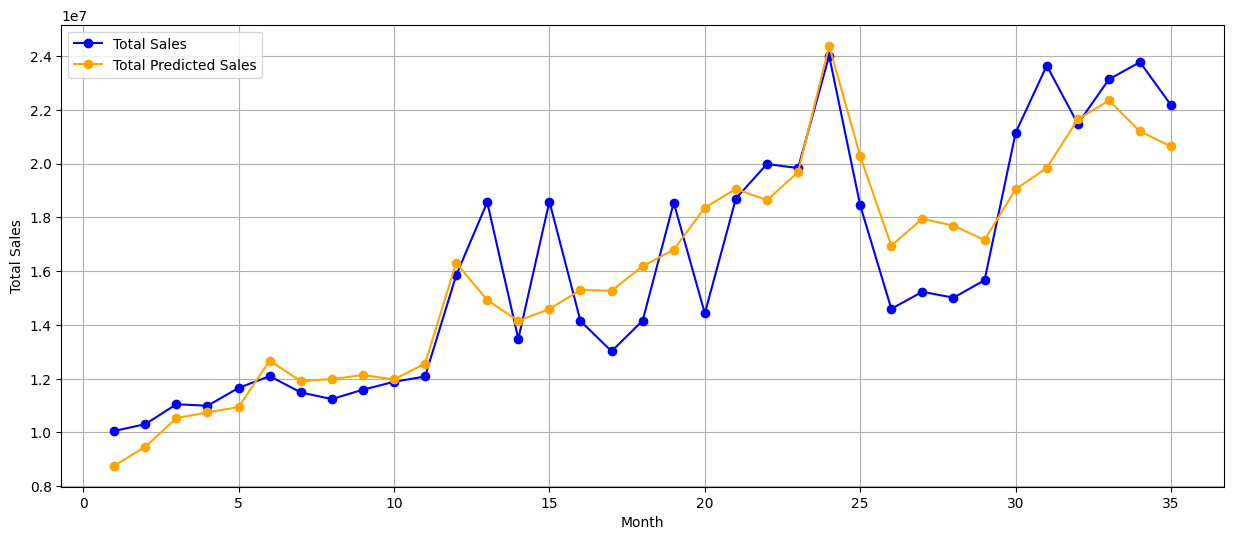

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Group train_data_total by date and store_nbr
lasso_grouped_data = lasso_train_data_total.groupby(['date', 'store_nbr']).sum()

# Determine the sales_month for each date
lasso_grouped_data['sales_month'] = (lasso_grouped_data.index.get_level_values(0) - 1) // 30 + 1

# Calculate total sales and total predicted sales per sales_month
lasso_total_sales_per_month = lasso_grouped_data.groupby('sales_month')['sales'].sum()
lasso_total_predicted_sales_per_month = lasso_grouped_data.groupby('sales_month')['predicted_sales'].sum()

# Plot total sales and total predicted sales per sales_month
plt.figure(figsize=(15, 6))  # Set the figure size
plt.plot(lasso_total_sales_per_month, label='Total Sales', marker='o', color='blue')
plt.plot(lasso_total_predicted_sales_per_month, label='Total Predicted Sales', marker='o', color='orange')

plt.xlabel('Month')
plt.ylabel('Total Sales')
#plt.title('Lasso Total Sales vs. Total Predicted Sales per Month')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
lasso_grouped_data

predicted_sales         sales  sales_month
date store_nbr                                            
1    25             1387.241796   2511.618999            1
2    1             10068.793209   7417.148000            1
     2             11888.250378  10266.718981            1
     3             20204.716550  24060.348000            1
     4              8676.576994  10200.083980            1
...                         ...           ...          ...
1050 49            22005.671155  35185.608000           35
     50            14759.282981  15705.604000           35
     51            13847.262553  26486.067980           35
     53             6808.256985   6883.006996           35
     54             7290.341544   5538.265000           35

[50172 rows x 3 columns]

In [68]:
import numpy as np
import pandas as pd

# Assuming 'lasso_grouped_data' is your DataFrame containing 'predicted_sales', 'sales', and 'sales_month' columns

# Group the data by sales_month and sum the predicted_sales and sales values
monthly_sales = lasso_grouped_data.groupby('sales_month').agg({'predicted_sales': 'sum', 'sales': 'sum'}).reset_index()

# Calculate absolute error for each month
monthly_sales['absolute_error'] = np.abs(monthly_sales['sales'] - monthly_sales['predicted_sales'])

# Calculate percentage error for each month
monthly_sales['percentage_error'] = (monthly_sales['absolute_error'] / monthly_sales['sales']) * 100

# Calculate mean absolute error (MAE) and mean percentage error (MPE) for all months
mean_absolute_error = monthly_sales['absolute_error'].mean()
mean_percentage_error = monthly_sales['percentage_error'].mean()

# Display the results
print("Mean Absolute Error (MAE):", mean_absolute_error)
print("Mean Percentage Error (MPE):", mean_percentage_error)

Mean Absolute Error (MAE): 1445849.8389825416
Mean Percentage Error (MPE): 8.97292143945355


In [70]:
monthly_sales

,sales_month,predicted_sales,sales,absolute_error,percentage_error
0,1,8.763359e+06,1.005637e+07,1.293012e+06,12.857641
1,2,9.466145e+06,1.030911e+07,8.429674e+05,8.176916
2,3,1.053265e+07,1.104960e+07,5.169454e+05,4.678408
3,4,1.074452e+07,1.099346e+07,2.489475e+05,2.264505
4,5,1.094488e+07,1.165531e+07,7.104281e+05,6.095319
5,6,1.266731e+07,1.209636e+07,5.709500e+05,4.720015
6,7,1.191061e+07,1.148890e+07,4.217176e+05,3.670653
7,8,1.198657e+07,1.124124e+07,7.453267e+05,6.630287
8,9,1.213410e+07,1.159118e+07,5.429248e+05,4.683950
9,10,1.197284e+07,1.188350e+07,8.934832e+04,0.751869


In [65]:

# Assuming lasso_grouped_data contains columns 'predicted_sales' and 'sales'
predicted_sales = lasso_grouped_data['predicted_sales']
actual_sales = lasso_grouped_data['sales']

# Calculate absolute error
absolute_error = np.abs(actual_sales - predicted_sales)

# Calculate percent error
percent_error = (absolute_error / actual_sales) * 100

In [66]:
percent_error

date  store_nbr
1     25           44.767029
2     1            35.750200
      2            15.794057
      3            16.024837
      4            14.936220
                     ...    
1050  49           37.458318
      50            6.025372
      51           47.718693
      53            1.086008
      54           31.635838
Length: 50172, dtype: float64

In [67]:
average_percent_error = sum(percent_error) / len(percent_error)

print("Average Percent Error:", average_percent_error)

Average Percent Error: 25.99430804076886


Lasso Performance Testing Data

In [71]:
# Scale the input features
scaler = StandardScaler()
test_features_scaled = scaler.fit_transform(test_features)

lasso_predicted_test_sales = lasso_model.predict(test_features_scaled)

lasso_predicted_test_sales_df = pd.DataFrame(lasso_predicted_test_sales, index=test_features.index, columns=['predicted_sales'])

# Concatenate train_features, predicted_sales_df, and the actual sales
lasso_test_data_total = pd.concat([lasso_predicted_test_sales_df, test_sales], axis=1)

In [72]:
# Calculate MAE
lasso_mae_test = mean_absolute_error(lasso_test_data_total['sales'], lasso_test_data_total['predicted_sales'])

# Print MAE
print('Lasso Mean Absolute Error (MAE) on Test Data:', lasso_mae_test)

TypeError: 'numpy.float64' object is not callable

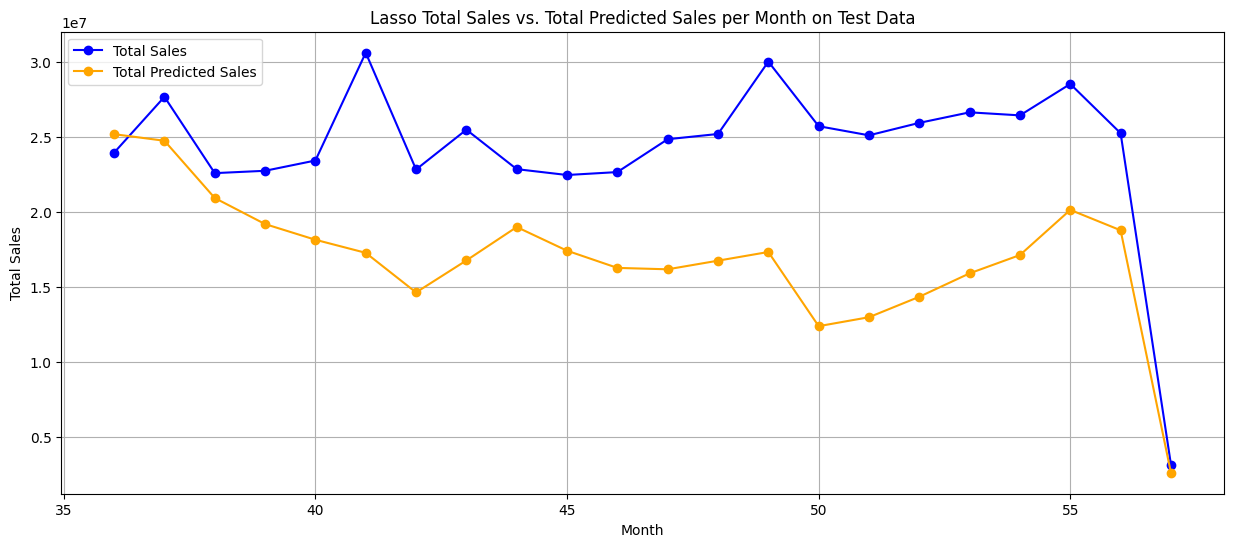

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Group train_data_total by date and store_nbr
lasso_grouped_data_test = lasso_test_data_total.groupby(['date', 'store_nbr']).sum()

# Determine the sales_month for each date
lasso_grouped_data_test['sales_month'] = (lasso_grouped_data_test.index.get_level_values(0) - 1) // 30 + 1

# Calculate total sales and total predicted sales per sales_month
lasso_total_sales_per_month_test = lasso_grouped_data_test.groupby('sales_month')['sales'].sum()
lasso_total_predicted_sales_per_month_test = lasso_grouped_data_test.groupby('sales_month')['predicted_sales'].sum()

# Plot total sales and total predicted sales per sales_month
plt.figure(figsize=(15, 6))  # Set the figure size
plt.plot(lasso_total_sales_per_month_test, label='Total Sales', marker='o', color='blue')
plt.plot(lasso_total_predicted_sales_per_month_test, label='Total Predicted Sales', marker='o', color='orange')

plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Lasso Total Sales vs. Total Predicted Sales per Month on Test Data')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
import numpy as np
import pandas as pd

# Assuming 'lasso_grouped_data' is your DataFrame containing 'predicted_sales', 'sales', and 'sales_month' columns

# Group the data by sales_month and sum the predicted_sales and sales values
monthly_sales = lasso_grouped_data_test.groupby('sales_month').agg({'predicted_sales': 'sum', 'sales': 'sum'}).reset_index()

# Calculate absolute error for each month
monthly_sales['absolute_error'] = np.abs(monthly_sales['sales'] - monthly_sales['predicted_sales'])

# Calculate percentage error for each month
monthly_sales['percentage_error'] = (monthly_sales['absolute_error'] / monthly_sales['sales']) * 100

# Calculate mean absolute error (MAE) and mean percentage error (MPE) for all months
mean_absolute_error = monthly_sales['absolute_error'].mean()
mean_percentage_error = monthly_sales['percentage_error'].mean()

# Display the results
print("Mean Absolute Error (MAE):", mean_absolute_error)
print("Mean Percentage Error (MPE):", mean_percentage_error)

Mean Absolute Error (MAE): 7387197.523061219
Mean Percentage Error (MPE): 29.330065910543397


--------------------

Ridge Regression

In [ ]:
from numpy import arange
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

# Scale the input features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)

# Define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)  # Reduce the number of splits and repeats

# Define model with automatic alpha selection and negative mean absolute error as scoring metric
ridge_model = RidgeCV(alphas=arange(0.1, 1, 0.1), cv=cv, scoring='neg_mean_absolute_error')  # Reduce the search space for alpha values

# Fit the model
ridge_model.fit(train_features_scaled, train_sales)

RidgeCV(alphas=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
        cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=1),
        scoring='neg_mean_absolute_error')

In [ ]:
# Summarize chosen configuration
print('Alpha selected by RidgeCV:', ridge_model.alpha_)

Alpha selected by RidgeCV: 0.9


Ridge Performance Training Data

In [ ]:
# Get the predicted sales from the Lasso regression model
ridge_predicted_sales = ridge_model.predict(train_features_scaled)

# Create a DataFrame with the predicted sales, using the same index as train_features
ridge_predicted_sales_df = pd.DataFrame(ridge_predicted_sales, index=train_features.index, columns=['predicted_sales'])

# Concatenate train_features, predicted_sales_df, and the actual sales
ridge_train_data_total = pd.concat([ridge_predicted_sales_df, train_sales], axis=1)

In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
ridge_mae = mean_absolute_error(ridge_train_data_total['sales'], ridge_train_data_total['predicted_sales'])

# Print MAE
print('Ridge Mean Absolute Error (MAE) on Train Data:', ridge_mae)

Ridge Mean Absolute Error (MAE) on Train Data: 2536.5664374949383


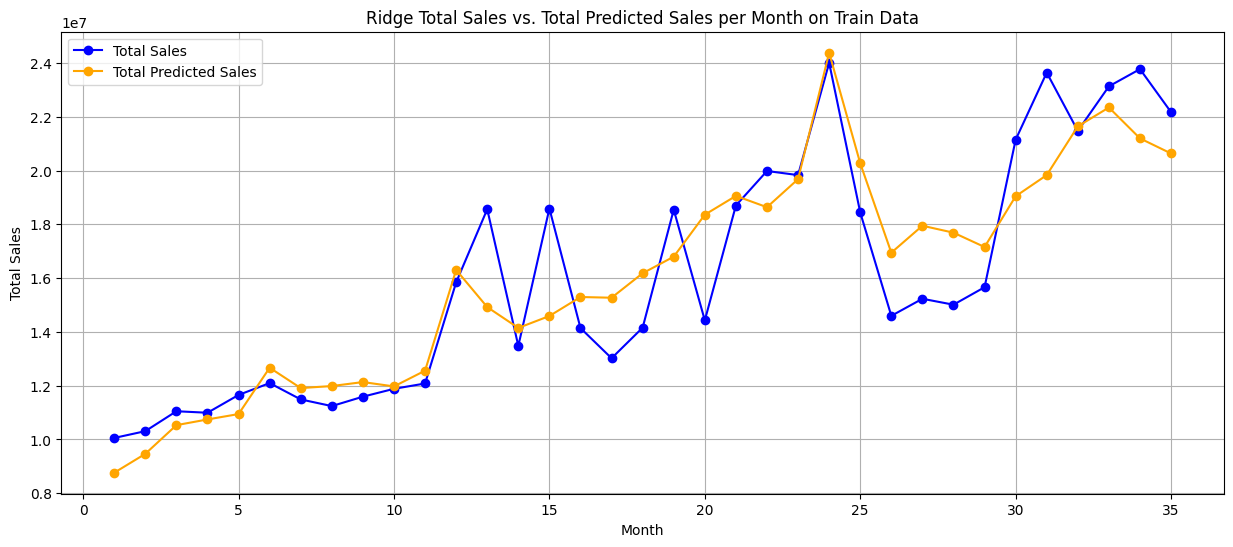

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Group train_data_total by date and store_nbr
ridge_grouped_data = ridge_train_data_total.groupby(['date', 'store_nbr']).sum()

# Determine the sales_month for each date
ridge_grouped_data['sales_month'] = (ridge_grouped_data.index.get_level_values(0) - 1) // 30 + 1

# Calculate total sales and total predicted sales per sales_month
ridge_total_sales_per_month = ridge_grouped_data.groupby('sales_month')['sales'].sum()
ridge_total_predicted_sales_per_month = ridge_grouped_data.groupby('sales_month')['predicted_sales'].sum()

# Plot total sales and total predicted sales per sales_month
plt.figure(figsize=(15, 6))  # Set the figure size
plt.plot(ridge_total_sales_per_month, label='Total Sales', marker='o', color='blue')
plt.plot(ridge_total_predicted_sales_per_month, label='Total Predicted Sales', marker='o', color='orange')

plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Ridge Total Sales vs. Total Predicted Sales per Month on Train Data')
plt.legend()
plt.grid(True)
plt.show()

Ridge Performance Testing Data

In [ ]:
# Scale the input features
scaler = StandardScaler()
test_features_scaled = scaler.fit_transform(test_features)

ridge_predicted_test_sales = ridge_model.predict(test_features_scaled)

ridge_predicted_test_sales_df = pd.DataFrame(ridge_predicted_test_sales, index=test_features.index, columns=['predicted_sales'])

# Concatenate train_features, predicted_sales_df, and the actual sales
ridge_test_data_total = pd.concat([ridge_predicted_test_sales_df, test_sales], axis=1)

In [ ]:
# Calculate MAE
ridge_mae_test = mean_absolute_error(ridge_test_data_total['sales'], ridge_test_data_total['predicted_sales'])

# Print MAE
print('Ridge Mean Absolute Error (MAE) on Test Data:', ridge_mae_test)

Ridge Mean Absolute Error (MAE) on Test Data: 5897.688451625191


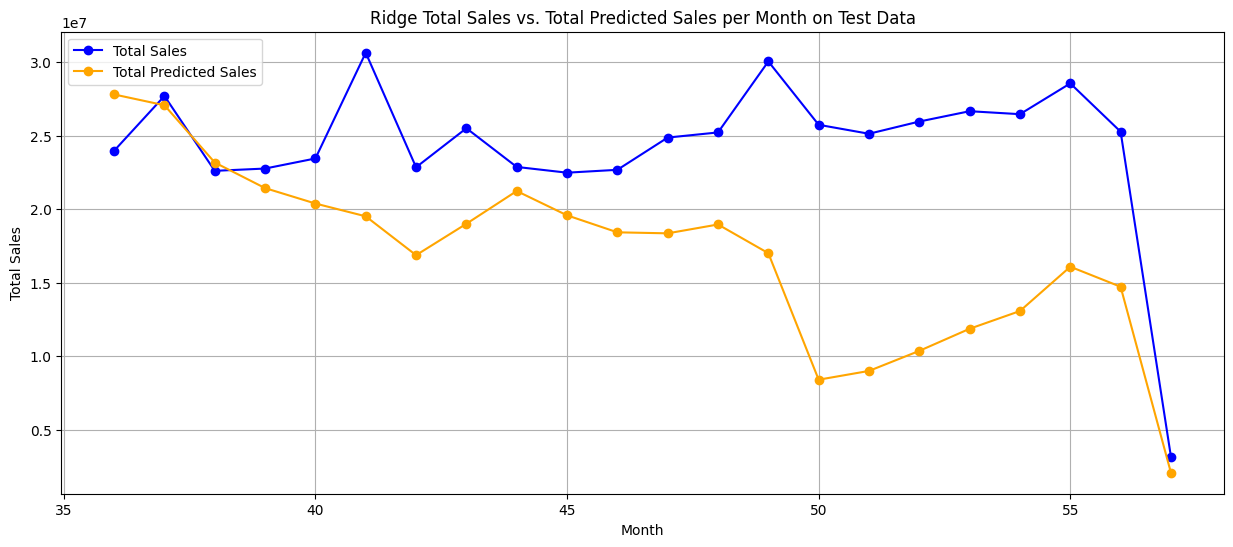

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Group train_data_total by date and store_nbr
ridge_grouped_data_test = ridge_test_data_total.groupby(['date', 'store_nbr']).sum()

# Determine the sales_month for each date
ridge_grouped_data_test['sales_month'] = (ridge_grouped_data_test.index.get_level_values(0) - 1) // 30 + 1

# Calculate total sales and total predicted sales per sales_month
ridge_total_sales_per_month_test = ridge_grouped_data_test.groupby('sales_month')['sales'].sum()
ridge_total_predicted_sales_per_month_test = ridge_grouped_data_test.groupby('sales_month')['predicted_sales'].sum()

# Plot total sales and total predicted sales per sales_month
plt.figure(figsize=(15, 6))  # Set the figure size
plt.plot(ridge_total_sales_per_month_test, label='Total Sales', marker='o', color='blue')
plt.plot(ridge_total_predicted_sales_per_month_test, label='Total Predicted Sales', marker='o', color='orange')

plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Ridge Total Sales vs. Total Predicted Sales per Month on Test Data')
plt.legend()
plt.grid(True)
plt.show()

------------------

SHAP Feature Analysis

In [ ]:
import pandas as pd

# Define the MAE values
mae_values = {
    "Linear MAE": [mae, mae_test],
    "Lasso MAE": [lasso_mae, lasso_mae_test],
    "Ridge MAE": [ridge_mae, ridge_mae_test]
}

# Create the mae_analysis DataFrame
mae_analysis = pd.DataFrame(mae_values, index=["Train", "Test"])

In [ ]:
mae_analysis

,Linear MAE,Lasso MAE,Ridge MAE
Train,2536.592977,2536.561945,2536.566437
Test,9234.121744,5405.999700,5897.688452


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
import shap

# Compute SHAP values
explainer = shap.Explainer(lasso_model, train_features)
shap_values = explainer.shap_values(train_features)

For Research

In [ ]:
import pandas as pd

# Assuming shap_values and train_features are already defined

# Create a DataFrame with SHAP values and features
shap_df = pd.DataFrame(data=shap_values, columns=train_features.columns)

# Add SHAP value number as a new column
shap_df['SHAP Value Number'] = range(1, len(shap_df) + 1)

# Melt the DataFrame to have SHAP values and features in separate rows
shap_df = shap_df.melt(id_vars='SHAP Value Number', var_name='Feature', value_name='SHAP Value')

# Filter out entries where the feature is 'transactions' or 'year'
shap_df_filtered = shap_df[~shap_df['Feature'].isin(['transactions', 'year'])]

# Group by feature and calculate the absolute sum of SHAP values
shap_df_grouped = shap_df_filtered.groupby('Feature')['SHAP Value'].sum().abs().reset_index()

# Filter out features with zero SHAP values
shap_df_grouped_nonzero = shap_df_grouped[shap_df_grouped['SHAP Value'] != 0]

# Calculate the magnitude of SHAP values
shap_df_grouped_nonzero['Magnitude'] = shap_df_grouped_nonzero['SHAP Value'].abs()

# Sort by the magnitude of SHAP values in descending order
shap_df_grouped_nonzero = shap_df_grouped_nonzero.sort_values(by='Magnitude', ascending=False)

# Reset index and update index values
shap_df_grouped_nonzero.index = range(1, len(shap_df_grouped_nonzero) + 1)

# Drop the magnitude column
shap_df_grouped_nonzero = shap_df_grouped_nonzero.drop(columns=['Magnitude'])

# Display the DataFrame
shap_df_grouped_nonzero


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Feature,SHAP Value
1,ecuador_labor_force,7.526079e+10
2,city_altitude,2.896282e+09
3,daily_oil_price,2.386530e+07
4,day_of_month,9.028124e+06
5,ecuador_gdp_growth,2.508446e+06
6,ecuador_inflation_rate,1.887469e+06
7,day_of_week_Sunday,1.016094e+06
8,ecuador_unemployment_rate,8.865833e+05
9,day_of_week_Saturday,4.140665e+05
10,days_till_holiday,3.769888e+05


In [ ]:
import pandas as pd

# Assuming train_features.columns and lasso_model.coef_ are defined

# Get non-zero coefficients and corresponding feature names
non_zero_coef = {feature: coef for feature, coef in zip(train_features.columns, lasso_model.coef_) if coef != 0}

# Define the desired features in the specified order
desired_features = [
    'ecuador_labor_force', 'city_altitude', 'daily_oil_price', 'day_of_month', 'ecuador_gdp_growth',
    'ecuador_inflation_rate', 'day_of_week_Sunday', 'ecuador_unemployment_rate', 'day_of_week_Saturday',
    'days_till_holiday'
]

# Filter the non-zero coefficients dictionary to include only the desired features
filtered_non_zero_coef = {feature: non_zero_coef[feature] for feature in desired_features if feature in non_zero_coef}

# Create lists to store data
features = list(filtered_non_zero_coef.keys())
actual_relationships = ['Positive' if filtered_non_zero_coef[feature] > 0 else 'Negative' for feature in features]

# Create the DataFrame
lasso_analysis = pd.DataFrame({
    'Feature': features,
    'Actual Relationship': actual_relationships
})

# Display the DataFrame with only the 'Actual Relationship' column
lasso_analysis.index = range(1, len(lasso_analysis) + 1)
lasso_analysis

,Feature,Actual Relationship
1,ecuador_labor_force,Negative
2,city_altitude,Negative
3,daily_oil_price,Negative
4,day_of_month,Negative
5,ecuador_gdp_growth,Positive
6,ecuador_inflation_rate,Positive
7,day_of_week_Sunday,Positive
8,ecuador_unemployment_rate,Positive
9,day_of_week_Saturday,Positive
10,days_till_holiday,Negative


------------------

In [ ]:
import pandas as pd

# Assuming train_features.columns and lasso_model.coef_ are defined

# Get non-zero coefficients and corresponding feature names
non_zero_coef = {feature: coef for feature, coef in zip(train_features.columns, lasso_model.coef_) if coef != 0}

# Define the desired features in the specified order
desired_features = [
    'ecuador_labor_force', 'city_altitude', 'daily_oil_price', 'day_of_month', 'ecuador_gdp_growth',
    'ecuador_inflation_rate', 'day_of_week_Sunday', 'ecuador_unemployment_rate', 'day_of_week_Saturday',
    'days_till_holiday'
]

# Filter the non-zero coefficients dictionary to include only the desired features
filtered_non_zero_coef = {feature: non_zero_coef[feature] for feature in desired_features if feature in non_zero_coef}

# Create the DataFrame
lasso_analysis = pd.DataFrame({
    'Feature': filtered_non_zero_coef.keys(),
    'Coefficient': filtered_non_zero_coef.values()
})

# Display the DataFrame with only the 'Feature' column
lasso_analysis.index = range(1, len(lasso_analysis) + 1)
lasso_analysis

,Feature,Coefficient
1,ecuador_labor_force,-811.798777
2,city_altitude,-146.001731
3,daily_oil_price,-1842.035836
4,day_of_month,-259.579831
5,ecuador_gdp_growth,1851.596166
6,ecuador_inflation_rate,1111.224865
7,day_of_week_Sunday,868.931487
8,ecuador_unemployment_rate,1057.965199
9,day_of_week_Saturday,224.918791
10,days_till_holiday,-98.385290


In [ ]:
coefficients = lasso_model.coef_

for i, coef in enumerate(coefficients):
  print(f'Coefficient {i+1}: {coef}')

Coefficient 1: 746.3561574160362
Coefficient 2: 1152.8515750118302
Coefficient 3: -259.5798309198821
Coefficient 4: -1842.035836270743
Coefficient 5: 7100.681974582805
Coefficient 6: -98.38528996917879
Coefficient 7: -146.00173118076484
Coefficient 8: 1851.596166460938
Coefficient 9: 1111.2248650969539
Coefficient 10: -811.7987772068694
Coefficient 11: 1057.965199389475
Coefficient 12: 290.53232060519724
Coefficient 13: -5.785927543441424
Coefficient 14: -0.0
Coefficient 15: -181.53404515252387
Coefficient 16: 3.971244480071551e-11
Coefficient 17: -114.77014893619277
Coefficient 18: 72.92210101259941
Coefficient 19: 224.91879134809977
Coefficient 20: 868.9314867668332
Coefficient 21: -246.8557153831308
Coefficient 22: -124.1622957881412
Coefficient 23: -0.0
Coefficient 24: -311.5434457425623
Coefficient 25: 0.0
Coefficient 26: -0.0
Coefficient 27: 247.86755155762006
Coefficient 28: 45.41265495835829
Coefficient 29: 37.40125872228306
Coefficient 30: -0.0
Coefficient 31: -66.933417248800

In [ ]:
non_zero_coef = {feature: coef for feature, coef in zip(train_features.columns, lasso_model.coef_) if coef != 0}

non_zero_coef

{'month': 746.3561574160362,
 'year': 1152.8515750118302,
 'day_of_month': -259.5798309198821,
 'daily_oil_price': -1842.035836270743,
 'transactions': 7100.681974582805,
 'days_till_holiday': -98.38528996917879,
 'city_altitude': -146.00173118076484,
 'ecuador_gdp_growth': 1851.596166460938,
 'ecuador_inflation_rate': 1111.2248650969539,
 'ecuador_labor_force': -811.7987772068694,
 'ecuador_unemployment_rate': 1057.965199389475,
 'ecuador_dependency_ratio': 290.53232060519724,
 'ecuador_cpi': -5.785927543441424,
 'is_holiday_False': -181.53404515252387,
 'is_holiday_True': 3.971244480071551e-11,
 'day_of_week_Friday': -114.77014893619277,
 'day_of_week_Monday': 72.92210101259941,
 'day_of_week_Saturday': 224.91879134809977,
 'day_of_week_Sunday': 868.9314867668332,
 'day_of_week_Thursday': -246.8557153831308,
 'day_of_week_Tuesday': -124.1622957881412,
 'city_Ambato': -311.5434457425623,
 'city_Cuenca': 247.86755155762006,
 'city_Daule': 45.41265495835829,
 'city_El Carmen': 37.401258

In [ ]:
# Create a DataFrame with SHAP values and features
shap_df = pd.DataFrame(data=shap_values, columns=train_features.columns)

# Add SHAP value number as a new column
shap_df['SHAP Value Number'] = range(1, len(shap_df) + 1)

# Melt the DataFrame to have SHAP values and features in separate rows
shap_df = shap_df.melt(id_vars='SHAP Value Number', var_name='Feature', value_name='SHAP Value')

# Group by feature and calculate the absolute sum of SHAP values
shap_df_grouped = shap_df.groupby('Feature')['SHAP Value'].sum().abs().reset_index()

# Filter out features with zero SHAP values
shap_df_grouped_nonzero = shap_df_grouped[shap_df_grouped['SHAP Value'] != 0]

# Calculate the magnitude of SHAP values
shap_df_grouped_nonzero.loc[:, 'magnitude'] = shap_df_grouped_nonzero['SHAP Value'].abs()

# Sort by the magnitude of SHAP values in descending order
shap_df_grouped_nonzero = shap_df_grouped_nonzero.sort_values(by='magnitude', ascending=False)

# Reset index and update index values
shap_df_grouped_nonzero.index = range(1, len(shap_df_grouped_nonzero) + 1)

# Drop the magnitude column
shap_df_grouped_nonzero = shap_df_grouped_nonzero.drop(columns=['magnitude'])

# Display the DataFrame
shap_df_grouped_nonzero



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Feature,SHAP Value
1,ecuador_labor_force,7.526079e+10
2,transactions,6.853472e+09
3,city_altitude,2.896282e+09
4,daily_oil_price,2.386530e+07
5,day_of_month,9.028124e+06
6,ecuador_gdp_growth,2.508446e+06
7,ecuador_inflation_rate,1.887469e+06
8,year,1.491467e+06
9,day_of_week_Sunday,1.016094e+06
10,ecuador_unemployment_rate,8.865833e+05


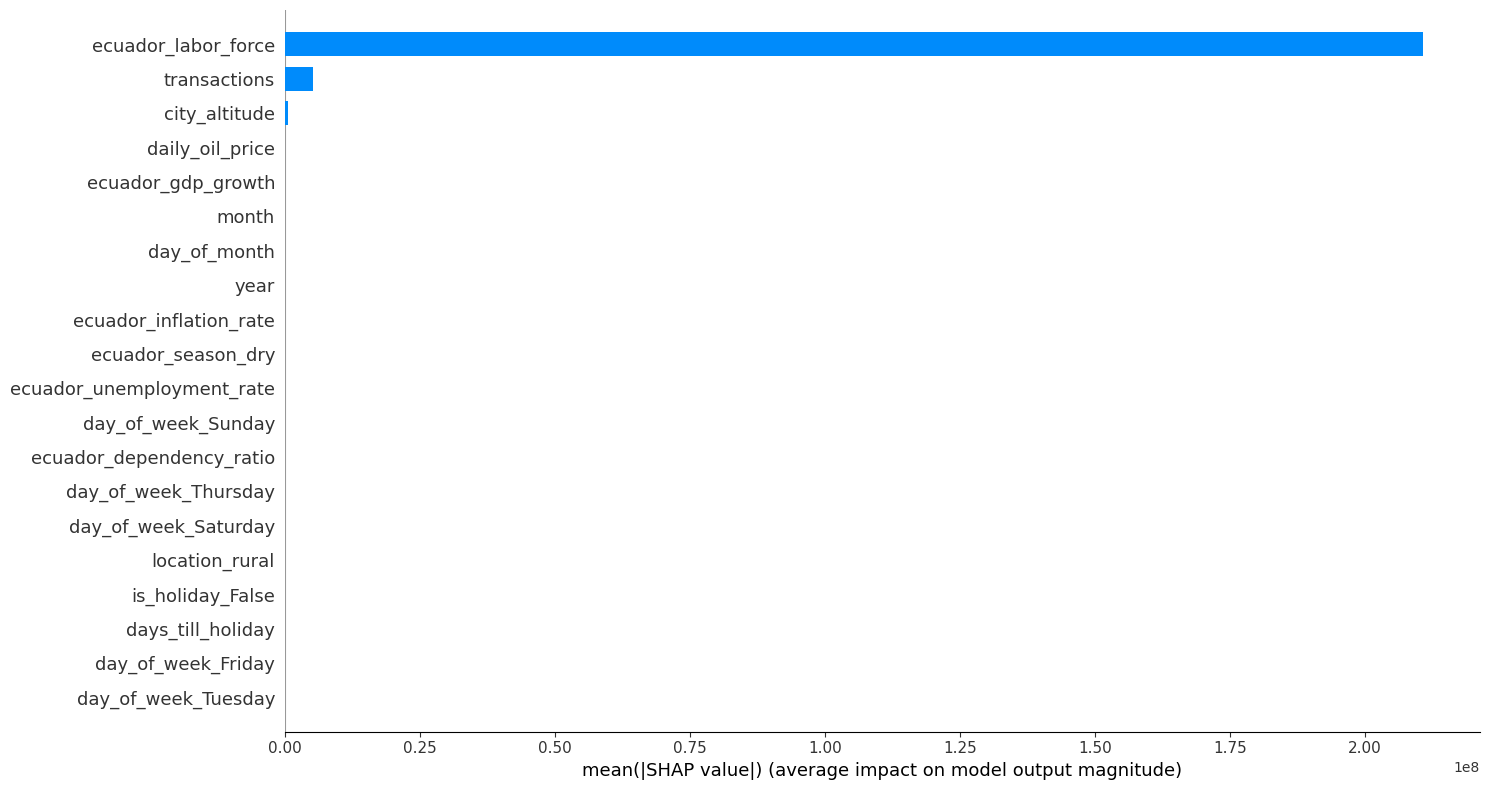

In [ ]:
# Summarize the SHAP values with custom figure size
shap.summary_plot(shap_values, train_features, plot_type='bar', plot_size=(15, 8))

In [ ]:
import pandas as pd

# Assuming train_features.columns and lasso_model.coef_ are defined

# Get non-zero coefficients and corresponding feature names
non_zero_coef = {feature: coef for feature, coef in zip(train_features.columns, lasso_model.coef_) if coef != 0}

# Define the desired features in the specified order
desired_features = [
    'ecuador_labor_force', 'city_altitude', 'daily_oil_price', 'day_of_month', 'ecuador_gdp_growth',
    'ecuador_inflation_rate', 'day_of_week_Sunday', 'ecuador_unemployment_rate', 'day_of_week_Saturday',
    'days_till_holiday'
]

# Filter the non-zero coefficients dictionary to include only the desired features
filtered_non_zero_coef = {feature: non_zero_coef[feature] for feature in desired_features if feature in non_zero_coef}

# Create lists to store data
features = list(filtered_non_zero_coef.keys())
actual_relationships = ['Positive' if filtered_non_zero_coef[feature] > 0 else 'Negative' for feature in features]

# Create the DataFrame
lasso_analysis = pd.DataFrame({
    'Feature': features,
    'Actual Relationship': actual_relationships
})

# Display the DataFrame with only the 'Actual Relationship' column
lasso_analysis.index = range(1, len(lasso_analysis) + 1)
lasso_analysis


,Feature,Actual Relationship
1,ecuador_labor_force,Negative
2,city_altitude,Negative
3,daily_oil_price,Negative
4,day_of_month,Negative
5,ecuador_gdp_growth,Positive
6,ecuador_inflation_rate,Positive
7,day_of_week_Sunday,Positive
8,ecuador_unemployment_rate,Positive
9,day_of_week_Saturday,Positive
10,days_till_holiday,Negative


-------------------------

In [ ]:
# Get the coefficients of the Lasso model
coefficients = lasso_model.coef_

# Find features with zero coefficients
zero_coef_features = train_features.columns[coefficients == 0]

# Create a DataFrame to display features with zero coefficients
zero_coef_df = pd.DataFrame({'Feature': zero_coef_features})

# Reset index of the DataFrame starting from 1
zero_coef_df.reset_index(drop=True, inplace=True)
zero_coef_df.index = zero_coef_df.index + 1

zero_coef_df

,Feature
1,ecuador_median_age
2,day_of_week_Wednesday
3,city_Babahoyo
4,city_Cayambe
5,city_Esmeraldas
6,city_Quito
7,state_Chimborazo
8,state_Esmeraldas
9,state_Guayas
10,state_Manabi


Data Processing


In [3]:
holidays_events_df = pd.read_csv("/content/holidays_events.csv")
oil_df = pd.read_csv("/content/oil.csv")
store_df = pd.read_csv("/content/stores.csv")
first_df = pd.read_csv("/content/train.csv")
transactions_df = pd.read_csv("/content/transactions.csv")

In [4]:
# View the first date
first_date = first_df['date'].head(1).values[0]
print("First Date in first_df:", first_date)

# View the last date
last_date = first_df['date'].tail(1).values[0]
print("Last Date in first_df:", last_date)


First Date in first_df: 2013-01-01
Last Date in first_df: 2017-08-15


In [5]:
clean_df = first_df.dropna()

print(clean_df.isnull().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [6]:
clean_df['date'] = pd.to_datetime(clean_df['date'])

In [7]:
oil_df['date'] = pd.to_datetime(oil_df['date'])

In [8]:
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

In [9]:
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])

In [10]:
oil_df.rename(columns={'dcoilwtico': 'daily_oil_price'}, inplace=True)

In [11]:
clean_df['store_nbr'] = clean_df['store_nbr'].astype(int)

In [12]:
# Check for duplicate rows
duplicate_rows = clean_df[clean_df.duplicated()]

# Display duplicate rows (if any)
if not duplicate_rows.empty:
    print("Duplicate Rows:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

No duplicate rows found.


EDA Visualization

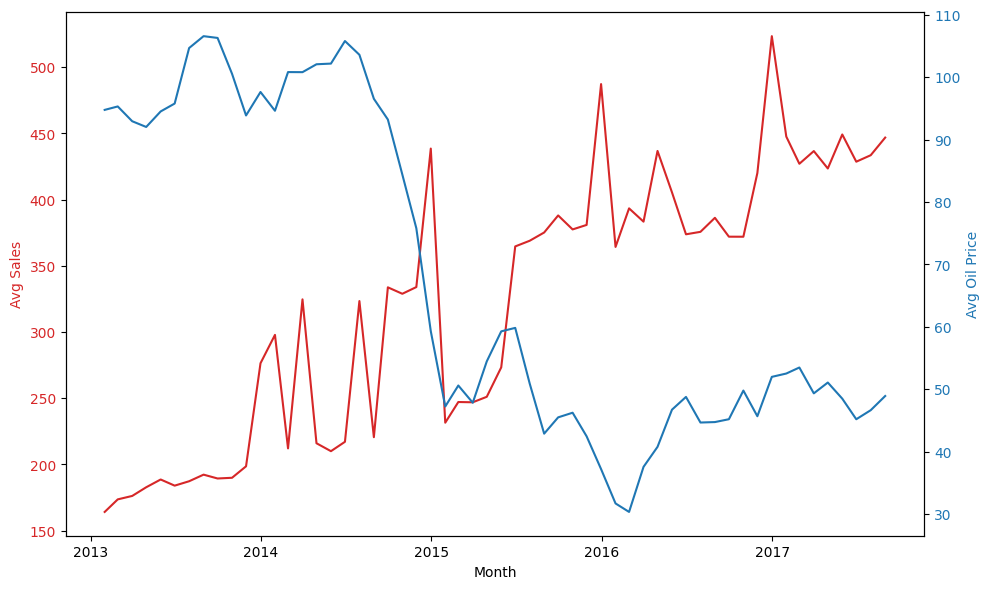

In [25]:
# Merge clean_df and oil_df on 'date'
merged_df = pd.merge(clean_df, oil_df, on='date')

# Calculate average sales revenue per day
daily_avg_sales = merged_df.groupby('date')['sales'].mean()

# Group by month and calculate average sales revenue per month
monthly_avg_sales = daily_avg_sales.resample('M').mean()

# Group oil prices by month and calculate average oil price per month
monthly_avg_oil_price = merged_df.groupby(pd.Grouper(key='date', freq='M'))['daily_oil_price'].mean()

# Plot average oil prices and average sales revenue by month
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Avg Sales', color=color)
ax1.plot(monthly_avg_sales.index, monthly_avg_sales.values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Avg Oil Price', color=color)
ax2.plot(monthly_avg_oil_price.index, monthly_avg_oil_price.values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
#plt.title('Average Sales vs Average Oil Price by Month')
plt.show()

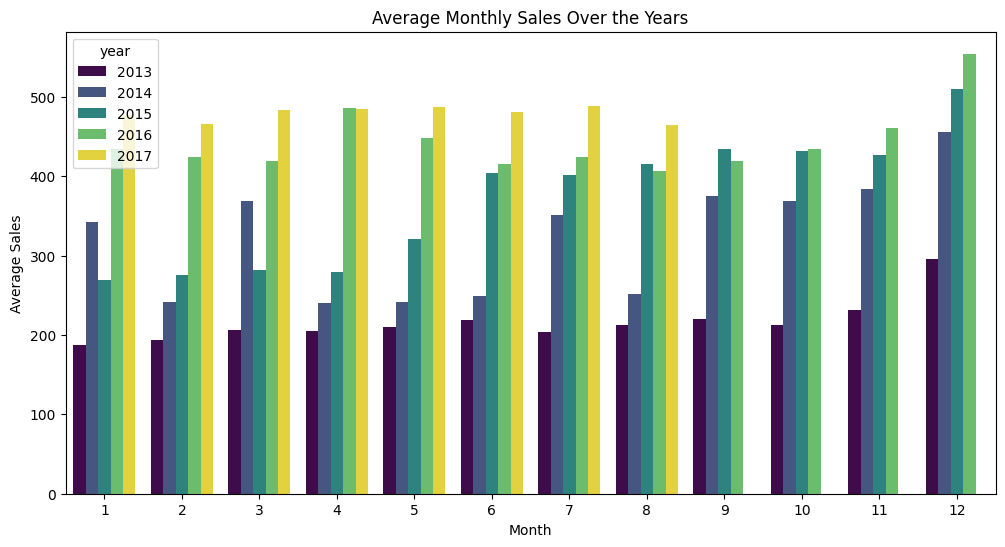

In [26]:
# Extract month and year information
clean_df['month'] = clean_df['date'].dt.month
clean_df['year'] = clean_df['date'].dt.year

# Group by month and year, calculate average sales
monthly_avg_sales = clean_df.groupby(['year', 'month'])['sales'].mean().reset_index()

# Create a bar chart using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='sales', hue='year', data=monthly_avg_sales, palette='viridis')
plt.title('Average Monthly Sales Over the Years')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.show()

<ipython-input-27-d54e378ec9a2>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  weekly_avg_sales = clean_df.groupby(clean_df['date'].dt.week)['sales'].mean()


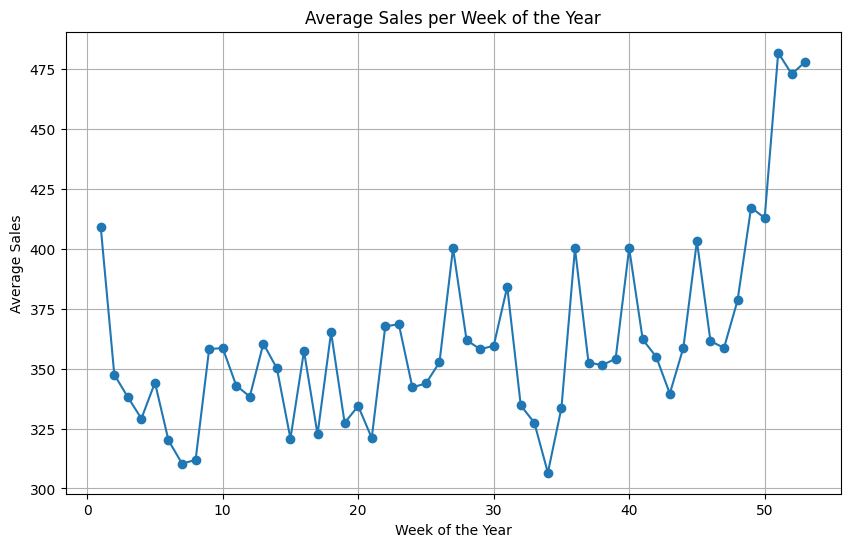

In [27]:
# Group dates into weeks and calculate average sales per week
weekly_avg_sales = clean_df.groupby(clean_df['date'].dt.week)['sales'].mean()

# Plot average sales for each week of the year
plt.figure(figsize=(10, 6))
plt.plot(weekly_avg_sales.index, weekly_avg_sales.values, marker='o', linestyle='-')
plt.title('Average Sales per Week of the Year')
plt.xlabel('Week of the Year')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

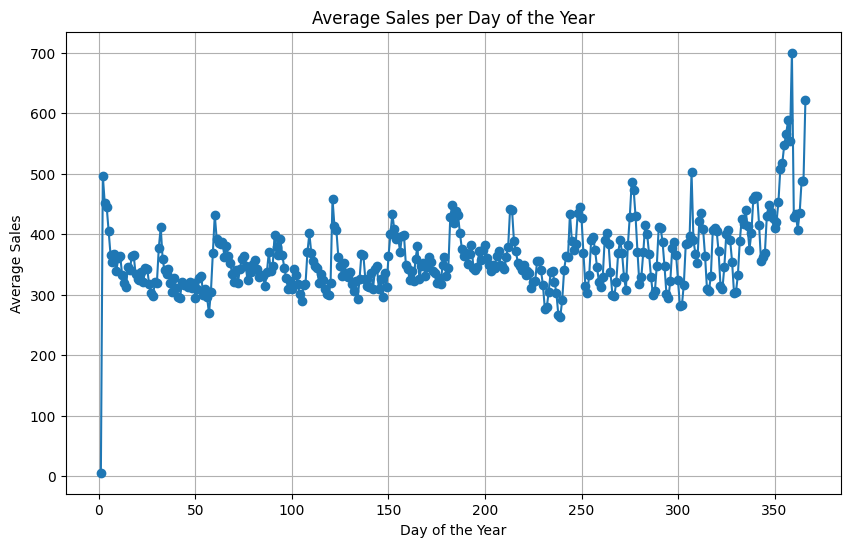

In [28]:
# Group dates by day and calculate average sales per day
daily_avg_sales = clean_df.groupby(clean_df['date'].dt.dayofyear)['sales'].mean()

# Plot average sales for each day of the year
plt.figure(figsize=(10, 6))
plt.plot(daily_avg_sales.index, daily_avg_sales.values, marker='o', linestyle='-')
plt.title('Average Sales per Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

In [29]:
# Calculate average sales per month for each product family
monthly_avg_sales_per_family = clean_df.groupby(['family', pd.Grouper(key='date', freq='M')])['sales'].mean().reset_index()

# Calculate total sales per product family
total_sales_per_family = monthly_avg_sales_per_family.groupby('family')['sales'].sum()

# Calculate percentage contribution for each product family
percentage_contribution_per_family = (total_sales_per_family / total_sales_per_family.sum()) * 100

# Get the top 10 selling product families based on average sales per month
top_10_product_families = total_sales_per_family.nlargest(10)

# Calculate the percentage contribution of each top product family
percentage_contribution_top_10 = (top_10_product_families / total_sales_per_family.sum()) * 100

# Combine the top product families with their percentage contribution
top_product_families_with_percentage = pd.concat([top_10_product_families, percentage_contribution_top_10], axis=1)
top_product_families_with_percentage.columns = ['Total Sales', 'Percentage Contribution']

# Print the top product families with their percentage contribution
print("Top 10 Selling Product Families and their Percentage Contribution:")
print(top_product_families_with_percentage)

Top 10 Selling Product Families and their Percentage Contribution:
                 Total Sales  Percentage Contribution
family                                               
GROCERY I      211942.626765                31.981207
BEVERAGES      134041.673334                20.226297
PRODUCE         75876.933207                11.449494
CLEANING        60127.677678                 9.073001
DAIRY           39775.647451                 6.001970
BREAD/BAKERY    25977.043113                 3.919821
POULTRY         19648.063209                 2.964806
MEATS           19157.134684                 2.890727
PERSONAL CARE   15169.703781                 2.289041
DELI            14866.695582                 2.243319


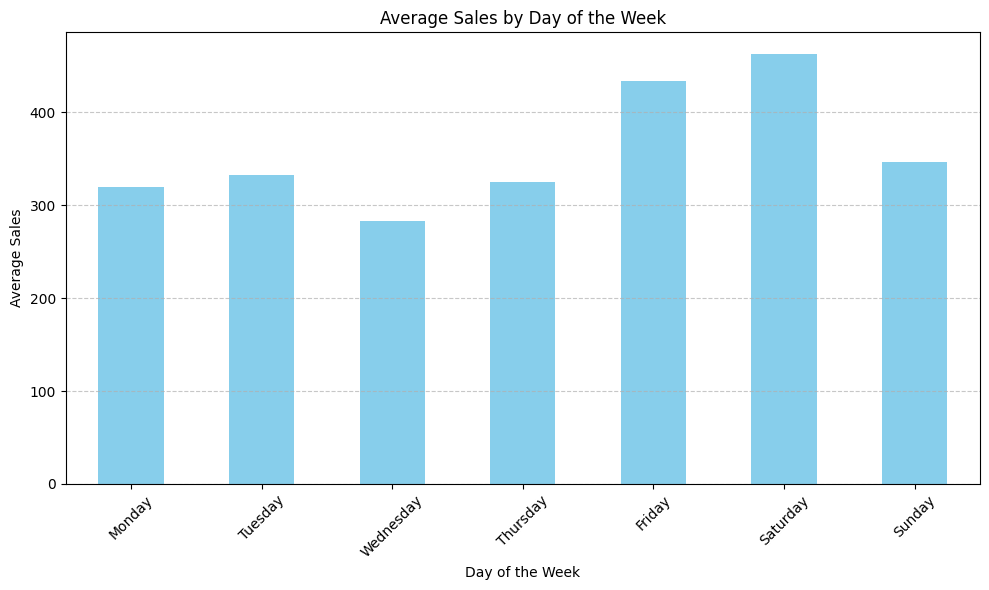

In [30]:
# Convert 'date' column to datetime format
clean_df['date'] = pd.to_datetime(clean_df['date'])

# Find the first date and its corresponding day of the week
first_date = clean_df['date'].min()
first_day_of_week = first_date.dayofweek  # 0 for Monday, 1 for Tuesday, ...

# Calculate the number of days to shift to make the first date Tuesday
days_to_shift = (first_day_of_week - 1) % 7

# Shift the dates to align the first date with Tuesday
clean_df['date'] = clean_df['date'] - pd.Timedelta(days=days_to_shift)

# Calculate total sales for each date
daily_total_sales = clean_df.groupby('date')['sales'].sum()

# Map day of the week to each date
day_of_week_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
clean_df['day_of_week'] = clean_df['date'].dt.dayofweek.map(day_of_week_map)

# Group by day of the week and calculate average sales
avg_sales_by_day_of_week = clean_df.groupby('day_of_week')['sales'].mean()

# Define the order of the days of the week for plotting
days_order = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday']

# Plot average sales by day of the week
plt.figure(figsize=(10, 6))
avg_sales_by_day_of_week[days_order].plot(kind='bar', color='skyblue')
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Modify the x-axis labels to start from Monday
plt.gca().set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.tight_layout()
plt.show()

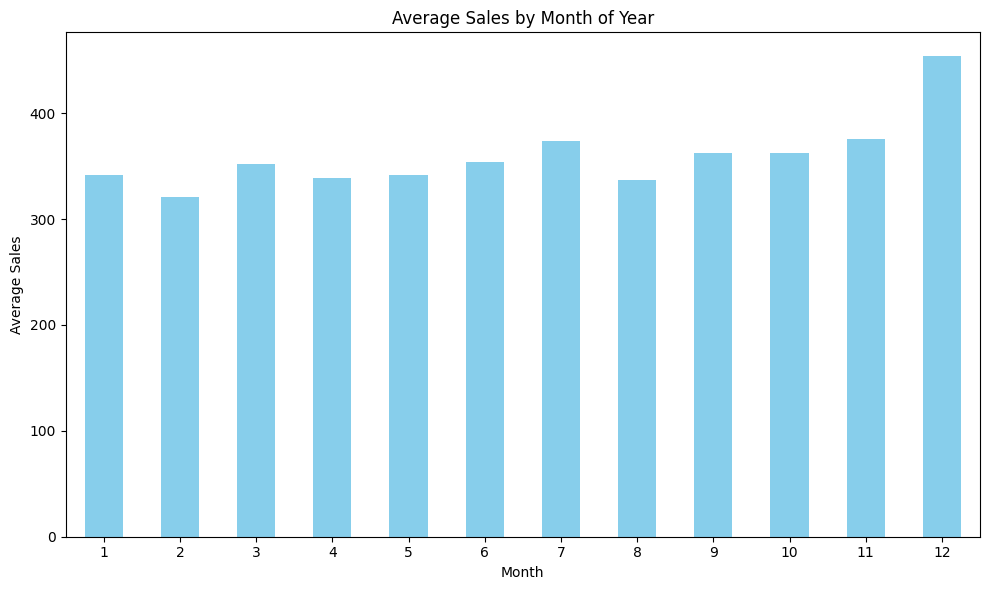

In [31]:
# Extract month from the 'date' column
clean_df['month'] = clean_df['date'].dt.month

# Group by month and calculate average sales
avg_sales_by_month = clean_df.groupby('month')['sales'].mean()

# Plot average sales by month
plt.figure(figsize=(10, 6))
avg_sales_by_month.plot(kind='bar', color='skyblue')
plt.title('Average Sales by Month of Year')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=0)  # Rotate x-axis labels to avoid overlapping
plt.tight_layout()
plt.show()

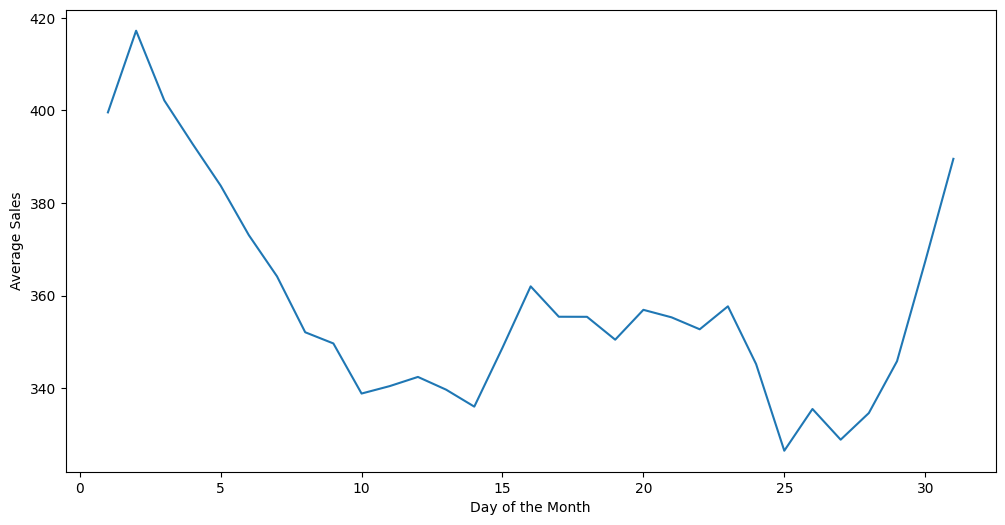

In [32]:
# Extract day of the month from the 'date' column
clean_df['day_of_month'] = clean_df['date'].dt.day

# Group by day of the month, calculate average sales
daily_avg_sales = clean_df.groupby('day_of_month')['sales'].mean().reset_index()

# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='day_of_month', y='sales', data=daily_avg_sales)
#plt.title('Average Sales for Each Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Average Sales')
plt.show()

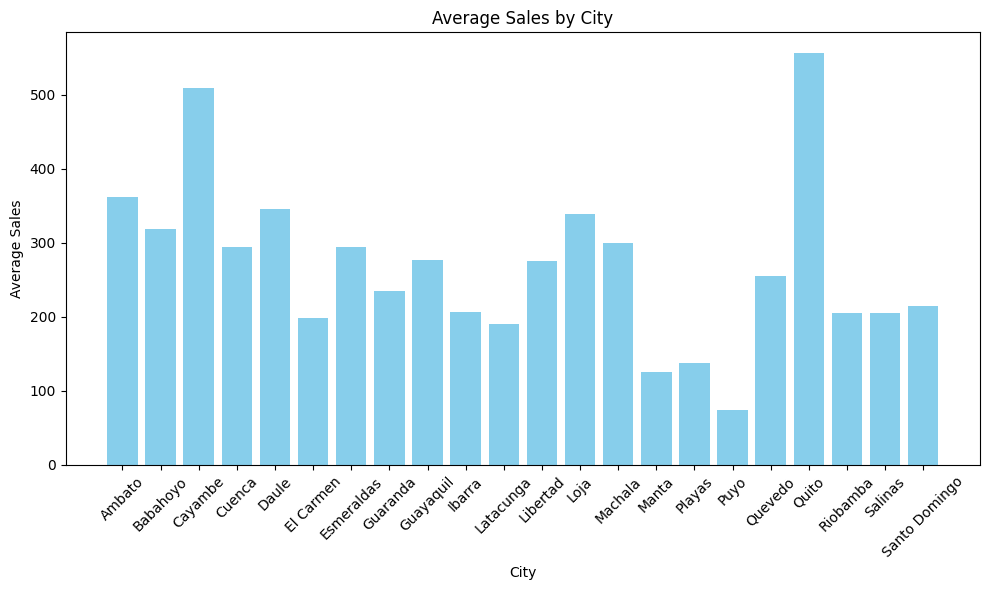

In [33]:
# Merge store_df with clean_df by store_nbr
merged_df = pd.merge(clean_df, store_df, on='store_nbr', how='left')

# Group by city and calculate average sales per city
city_avg_sales = merged_df.groupby('city')['sales'].mean().reset_index()

# Plot average sales per city as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(city_avg_sales['city'], city_avg_sales['sales'], color='skyblue')
plt.title('Average Sales by City')
plt.xlabel('City')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

FEATURE ENGINEERING

In [34]:
holidays_list = holidays_events_df['date'].tolist()
holidays_list = pd.to_datetime(holidays_list)

In [35]:
# Create a new column 'is_holiday' to identify if a date is a holiday
clean_df['is_holiday'] = clean_df['date'].isin(holidays_events_df['date'])

# Filter rows where the date is not a holiday and keep only unique dates
not_holidays_df = clean_df[~clean_df['is_holiday']].drop_duplicates('date').copy()

# Convert 'date' column to datetime format
not_holidays_df['date'] = pd.to_datetime(not_holidays_df['date'])

# Sort the dataframe by date for better calculation
not_holidays_df = not_holidays_df.sort_values(by='date')

# Update is_holiday based on transferred holidays
for index, row in holidays_events_df[holidays_events_df['type'] == 'Transfer'].iterrows():
    transferred_date = row['date']
    holiday_name = row['description']
    actual_date_df = holidays_events_df[(holidays_events_df['description'] == holiday_name) & (holidays_events_df['type'] == 'Holiday')]
    if not actual_date_df.empty:
        actual_date = actual_date_df['date'].values[0]
        not_holidays_df.loc[not_holidays_df['date'] == actual_date, 'is_holiday'] = True

# Calculate the days till the next upcoming holiday
not_holidays_df['days_till_holiday'] = (
    not_holidays_df['date'].shift(-1) - not_holidays_df['date']
).dt.days

# Replace the days_till_holiday with NaN for rows where the date is already a holiday
not_holidays_df.loc[not_holidays_df['is_holiday'], 'days_till_holiday'] = pd.NaT

# Drop the unnecessary columns
not_holidays_df = not_holidays_df[['date', 'days_till_holiday']]

# Reset the index if needed
not_holidays_df.reset_index(drop=True, inplace=True)

# Display the resulting dataframe
not_holidays_df.head()


,date,days_till_holiday
0,2013-01-02,1.0
1,2013-01-03,1.0
2,2013-01-04,2.0
3,2013-01-06,1.0
4,2013-01-07,1.0


In [36]:
store_df.drop(['type', 'cluster'], axis=1, inplace=True)
store_df.head()

KeyError: "['type', 'cluster'] not found in axis"

In [37]:
new_df = pd.merge(clean_df, oil_df, on='date', how='left')

new_df = pd.merge(new_df, store_df, on='store_nbr', how='left')

new_df = pd.merge(new_df, holidays_events_df, on=['date'], how='left')

new_df = pd.merge(new_df, transactions_df, on=['store_nbr','date'], how='left')

new_df = pd.merge(new_df, not_holidays_df, on=['date'], how='left')

In [38]:
new_df.drop(['locale','locale_name','description',	'transferred','type'	], axis=1, inplace=True)

In [39]:
new_df.rename(columns={'sales': 'family_sales'}, inplace=True)

In [40]:
# Step 1: Group by 'date' and 'store_nbr' and sum the 'family_sales' for each date and store_nbr
sales_per_date_store = new_df.groupby(['date', 'store_nbr'])['family_sales'].sum().reset_index()

# Step 2: Rename the sum column to 'sales'
sales_per_date_store.rename(columns={'family_sales': 'sales'}, inplace=True)

# Step 3: Merge the original DataFrame with the aggregated sales_per_date DataFrame
new_df = pd.merge(new_df, sales_per_date_store, on=['date', 'store_nbr'], how='left')

# Step 4: Drop the 'family' and 'family_sales' columns
new_df.drop(['family', 'family_sales'], axis=1, inplace=True)

In [41]:
new_df.drop(['id', 'onpromotion'], axis=1, inplace=True)

In [42]:
total_df = new_df.drop_duplicates()

In [43]:
total_df.reset_index(drop=True, inplace=True)

In [44]:
# Drop the entries where sales are equal to 0
total_df = total_df[total_df['sales'] != 0]

# Reset index after dropping rows
total_df.reset_index(drop=True, inplace=True)

In [45]:
# Dictionary to map Ecuadorian states to regions and identify coastal states
state_info = {
    'Pichincha': {'region': 'North', 'is_coastal': False},
    'Cotopaxi': {'region': 'Central', 'is_coastal': False},
    'Chimborazo': {'region': 'Central', 'is_coastal': False},
    'Imbabura': {'region': 'North', 'is_coastal': False},
    'Santo Domingo de los Tsachilas': {'region': 'West', 'is_coastal': False},
    'Bolivar': {'region': 'Central', 'is_coastal': False},
    'Pastaza': {'region': 'East', 'is_coastal': False},
    'Tungurahua': {'region': 'Central', 'is_coastal': False},
    'Guayas': {'region': 'West', 'is_coastal': True},
    'Santa Elena': {'region': 'West', 'is_coastal': True},
    'Los Rios': {'region': 'Central', 'is_coastal': True},
    'Azuay': {'region': 'South', 'is_coastal': False},
    'Loja': {'region': 'South', 'is_coastal': False},
    'El Oro': {'region': 'South', 'is_coastal': True},
    'Esmeraldas': {'region': 'West', 'is_coastal': True},
    'Manabi': {'region': 'West', 'is_coastal': True}
}

# Map states to regions and identify coastal states in total_df
total_df['region'] = total_df['state'].map(lambda x: state_info[x]['region'] if x in state_info else None)
total_df['is_coastal'] = total_df['state'].map(lambda x: state_info[x]['is_coastal'] if x in state_info else None)


In [46]:
# Define a dictionary mapping cities to their corresponding locations
city_location_mapping = {
    'Quito': 'urban',
    'Cayambe': 'rural',
    'Latacunga': 'rural',
    'Riobamba': 'rural',
    'Ibarra': 'rural',
    'Santo Domingo': 'urban',
    'Guaranda': 'rural',
    'Puyo': 'rural',
    'Ambato': 'urban',
    'Guayaquil': 'urban',
    'Salinas': 'urban',
    'Daule': 'urban',
    'Babahoyo': 'urban',
    'Quevedo': 'urban',
    'Playas': 'urban',
    'Libertad': 'urban',
    'Cuenca': 'urban',
    'Loja': 'urban',
    'Machala': 'urban',
    'Esmeraldas': 'urban',
    'Manta': 'urban',
    'El Carmen': 'urban'
}

# Map the cities to their corresponding locations using the dictionary
total_df['location'] = total_df['city'].map(city_location_mapping)

In [47]:
altitude_data_ft = {
    'Quito': 9350,
    'Cayambe': 18996,
    'Latacunga': 9055,
    'Riobamba': 9035,
    'Ibarra': 7300,
    'Santo Domingo': 2051,
    'Guaranda': 8753,
    'Puyo': 3116,
    'Ambato': 8455,
    'Guayaquil': 13,
    'Salinas': 12588,
    'Daule': 88,
    'Babahoyo': 26,
    'Quevedo': 243,
    'Playas': 476.25,
    'Libertad': 92,
    'Cuenca': 8517,
    'Loja': 6889,
    'Machala': 20,
    'Esmeraldas': 49,
    'Manta': 20,
    'El Carmen': 960
}

total_df['city_altitude'] = total_df['city'].map(altitude_data_ft)

In [48]:
# GDP growth data
gdp_growth_data = {
    2013: 4.9,
    2014: 3.8,
    2015: 0.1,
    2016: -1.2,
    2017: 2.4,
}

# Convert date column to datetime format
total_df['date'] = pd.to_datetime(total_df['date'])

# Extract year from the date column
total_df['year'] = total_df['date'].dt.year

# Add GDP growth data to total_df
total_df['ecuador_gdp_growth'] = total_df['year'].map(gdp_growth_data)

In [49]:
# Create a dictionary to map years to their corresponding inflation rates
inflation_rates = {
    2013: 2.7,
    2014: 3.6,
    2015: 4.0,
    2016: 1.7,
    2017: 0.4,
}

# Convert the 'date' column to datetime format to extract the year
total_df['date'] = pd.to_datetime(total_df['date'])

# Extract the year from the 'date' column
total_df['year'] = total_df['date'].dt.year

# Map the inflation rates to the corresponding years
total_df['ecuador_inflation_rate'] = total_df['year'].map(inflation_rates)

In [50]:
# Define the labor force data
labor_force_data = {
    2013: 6857058,
    2014: 7045425,
    2015: 7548658,
    2016: 7951902,
    2017: 8190955
}

# Map the labor force data to the 'year' column in total_df
total_df['ecuador_labor_force'] = total_df['year'].map(labor_force_data)

In [51]:
unemployment_rate = {
    2013: 3.1,
    2014: 3.5,
    2015: 3.6,
    2016: 4.6,
    2017: 3.8,
}

total_df['ecuador_unemployment_rate'] = total_df['year'].map(unemployment_rate)

In [52]:
dependency_ratio = {
    2013: 56.8,
    2014: 56.2,
    2015: 55.5,
    2016: 54.7,
    2017: 54.0,
}

total_df['ecuador_dependency_ratio'] = total_df['year'].map(dependency_ratio)

In [53]:
consumer_price_index = {
    2013: 112.8,
    2014: 116.8,
    2015: 121.5,
    2016: 123.6,
    2017: 124.1
}

total_df['ecuador_cpi'] = total_df['year'].map(consumer_price_index)

In [54]:
median_age = {
    2013: 24.7252,
    2014: 25.0635,
    2015: 25.4162,
    2016: 25.7791,
    2017: 26.1466,
}

total_df['ecuador_median_age'] = total_df['year'].map(median_age)

In [55]:
# Define a function to map months to seasons
def get_season(month):
    if month in [10, 11, 12, 1, 2, 3, 4, 5]:
        return 'dry'
    elif month in [6, 7, 8, 9]:
        return 'rainy'

# Add a new 'season' column to total_df
total_df['ecuador_season'] = total_df['month'].apply(get_season)

In [56]:
total_df['is_2016'] = total_df['year'] == 2016

In [57]:
# Define a function to check if a given day of the week is a weekend
def is_weekend(day_of_week):
    return day_of_week in ['Friday', 'Saturday', 'Sunday']

# Map day of the week to each date
day_of_week_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
total_df['day_of_week'] = total_df['date'].dt.dayofweek.map(day_of_week_map)

# Add the is_weekend feature based on the day of the week
total_df['is_weekend'] = total_df['day_of_week'].apply(is_weekend)

Fill Null Values with Interpolation

In [46]:
# 1. Interpolate missing daily_oil_price data using polynomial interpolation
total_df['new_oil_price_data'] = total_df['daily_oil_price'].interpolate(method='polynomial', order=2)

# 2. Substitute new_oil_price_data entries in the original daily_oil_price data only where it is null
total_df['daily_oil_price'] = total_df['daily_oil_price'].where(total_df['daily_oil_price'].notna(), total_df['new_oil_price_data'])

# 3. Drop new_oil_price_data
total_df.drop(columns=['new_oil_price_data'], inplace=True)

total_df['daily_oil_price'].fillna(method='bfill', inplace=True)

In [47]:
# Interpolate missing transactions data into a new column using linear interpolation
total_df['new_transactions_data'] = total_df['transactions'].interpolate(method='linear')

# Substitute new transactions data entries into the original transactions data only where it is null
total_df['transactions'] = total_df['transactions'].fillna(total_df['new_transactions_data'])

# Drop the new_transactions_data column
total_df.drop(columns=['new_transactions_data'], inplace=True)

total_df['transactions'].fillna(method='bfill', inplace=True)

In [48]:
# Fill null values in the 'days_till_holiday' column with 0
total_df['days_till_holiday'].fillna(0, inplace=True)

In [49]:
# Calculate the percentage of null values for each column
null_percentage = (total_df.isnull().sum() / len(total_df)) * 100

# Print the percentage of null values for each column
print("Percentage of null values for each column:")
print(null_percentage)

Percentage of null values for each column:
date                         0.0
store_nbr                    0.0
day_of_month                 0.0
month                        0.0
year                         0.0
day_of_week                  0.0
is_holiday                   0.0
daily_oil_price              0.0
city                         0.0
state                        0.0
transactions                 0.0
days_till_holiday            0.0
sales                        0.0
region                       0.0
is_coastal                   0.0
location                     0.0
city_altitude                0.0
ecuador_gdp_growth           0.0
ecuador_inflation_rate       0.0
ecuador_labor_force          0.0
ecuador_unemployment_rate    0.0
ecuador_dependency_ratio     0.0
ecuador_cpi                  0.0
ecuador_median_age           0.0
ecuador_season               0.0
is_2016                      0.0
is_weekend                   0.0
dtype: float64


One Hot Encoding

In [50]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83606 entries, 0 to 83605
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       83606 non-null  datetime64[ns]
 1   store_nbr                  83606 non-null  int64         
 2   day_of_month               83606 non-null  int64         
 3   month                      83606 non-null  int64         
 4   year                       83606 non-null  int64         
 5   day_of_week                83606 non-null  object        
 6   is_holiday                 83606 non-null  bool          
 7   daily_oil_price            83606 non-null  float64       
 8   city                       83606 non-null  object        
 9   state                      83606 non-null  object        
 10  transactions               83606 non-null  float64       
 11  days_till_holiday          83606 non-null  float64       
 12  sale

In [51]:
total_df = pd.get_dummies(total_df, columns=['is_holiday','day_of_week','city','state','region','is_coastal','location','ecuador_season','is_2016','is_weekend'])

In [52]:
import datetime as dt
# Sort the DataFrame by date
total_df.sort_values(by='date', inplace=True)

# Find unique dates and assign ordinal values
unique_dates = total_df['date'].unique()
ordinal_encoding = {date: i+1 for i, date in enumerate(unique_dates)}

# Apply ordinal encoding to the 'date' column
total_df['date'] = total_df['date'].map(ordinal_encoding)

In [53]:
total_df.reset_index(drop=True, inplace=True)

Engineered Features Visualization

In [ ]:
total_df['date'] = pd.to_datetime(total_df['date'])

# Extract the year from the 'date' column
total_df['year'] = total_df['date'].dt.year

# Group by region and year, calculate the average sales
avg_sales_per_year_region = total_df.groupby(['region', 'year'])['sales'].mean().unstack()

# Plotting the bar chart
plt.figure(figsize=(12, 8))
avg_sales_per_year_region.plot(kind='bar', cmap='viridis', edgecolor='black')

plt.title('Average Sales per Year in Each Region')
plt.xlabel('Region')
plt.ylabel('Average Sales')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

KeyError: 'region'

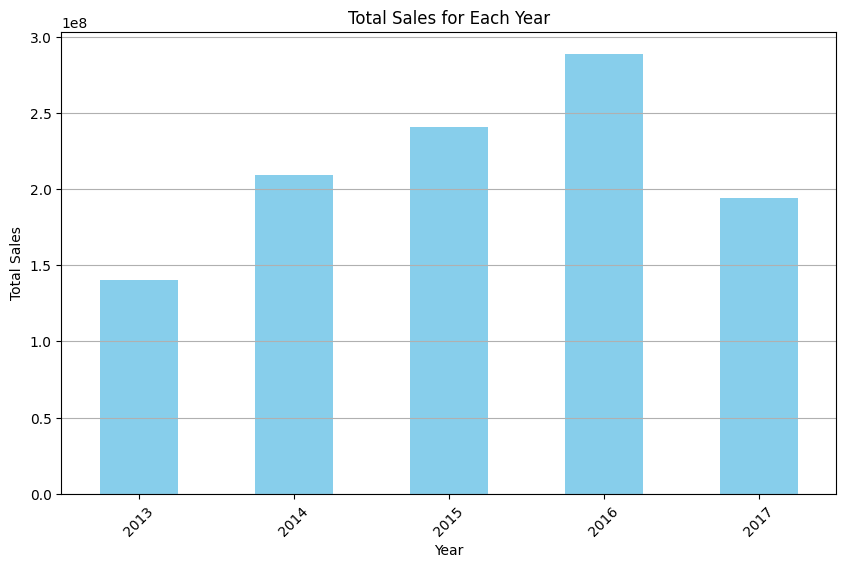

In [ ]:
# Extract year from the 'date' column
clean_df['year'] = clean_df['date'].dt.year

# Group by year and calculate total sales
yearly_sales = clean_df.groupby('year')['sales'].sum()

# Plot total sales for each year
plt.figure(figsize=(10, 6))
yearly_sales.plot(kind='bar', color='skyblue')
plt.title('Total Sales for Each Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [ ]:
# Extract the year from the 'date' column
total_df['year'] = total_df['date'].dt.year

# Filter DataFrame for holidays and non-holidays
holidays_df = total_df[total_df['is_holiday'] == True]
non_holidays_df = total_df[total_df['is_holiday'] == False]

# Calculate average sales per year for holidays and non-holidays
avg_sales_holidays = holidays_df.groupby('year')['sales'].mean()
avg_sales_non_holidays = non_holidays_df.groupby('year')['sales'].mean()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
avg_sales_holidays.plot(kind='bar', color='skyblue', label='Holidays', alpha=0.7)
avg_sales_non_holidays.plot(kind='bar', color='lightcoral', label='Non-Holidays', alpha=0.7)

plt.title('Average Sales on Holidays vs Non-Holidays per Year')
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.legend()
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

KeyError: 'is_holiday'

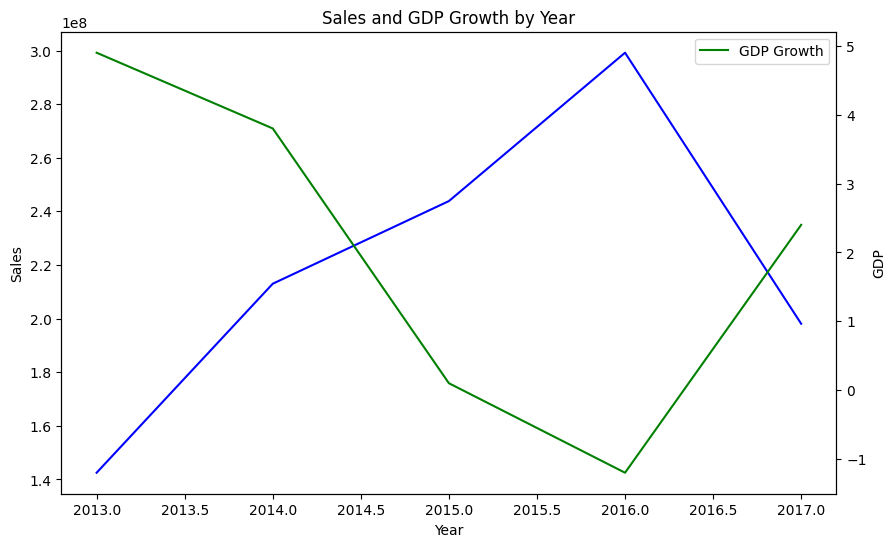

In [ ]:
# Group sales and Ecuador GDP by year
sales_by_year = total_df.groupby(total_df['date'].dt.year)['sales'].sum()
gdp_by_year = total_df.groupby(total_df['date'].dt.year)['ecuador_gdp_growth'].mean()

# Plot sales by year
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year.index, sales_by_year.values, label='Sales', color='blue')
plt.xlabel('Year')
plt.ylabel('Sales')

# Create a second y-axis for GDP
plt.twinx()
plt.plot(gdp_by_year.index, gdp_by_year.values, label='GDP Growth', color='green')
plt.ylabel('GDP')

# Add title and legend
plt.title('Sales and GDP Growth by Year')
plt.legend()

plt.show()

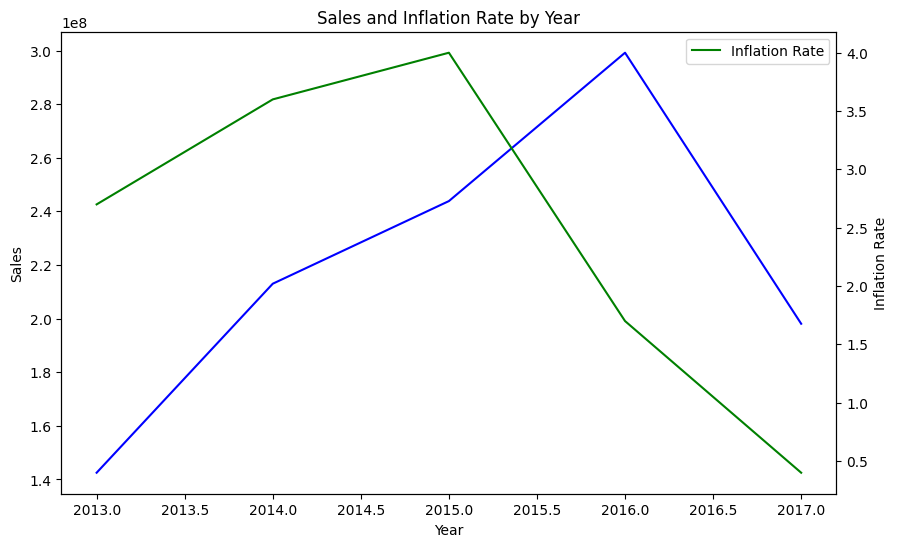

In [ ]:
# Group sales and Ecuador Inflation by year
sales_by_year = total_df.groupby(total_df['date'].dt.year)['sales'].sum()
inflation_by_year = total_df.groupby(total_df['date'].dt.year)['ecuador_inflation_rate'].mean()

# Plot sales by year
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year.index, sales_by_year.values, label='Sales', color='blue')
plt.xlabel('Year')
plt.ylabel('Sales')

# Create a second y-axis for Inflation
plt.twinx()
plt.plot(inflation_by_year.index, inflation_by_year.values, label='Inflation Rate', color='green')
plt.ylabel('Inflation Rate')

# Add title and legend
plt.title('Sales and Inflation Rate by Year')
plt.legend()

plt.show()

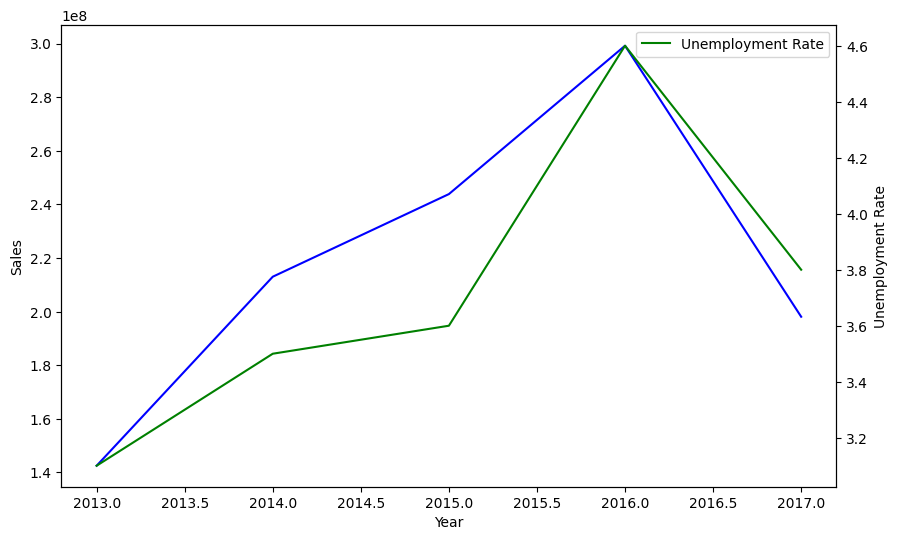

In [58]:
# Group sales and Ecuador Unemployment Rates by year
sales_by_year = total_df.groupby(total_df['date'].dt.year)['sales'].sum()
unemployment_by_year = total_df.groupby(total_df['date'].dt.year)['ecuador_unemployment_rate'].mean()

# Plot sales by year
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year.index, sales_by_year.values, label='Sales', color='blue')
plt.xlabel('Year')
plt.ylabel('Sales')

# Create a second y-axis for Unemployment Rates
plt.twinx()
plt.plot(unemployment_by_year.index, unemployment_by_year.values, label='Unemployment Rate', color='green')
plt.ylabel('Unemployment Rate')

# Add title and legend
#plt.title('Sales and Unemployment Rate by Year')
plt.legend()

plt.show()

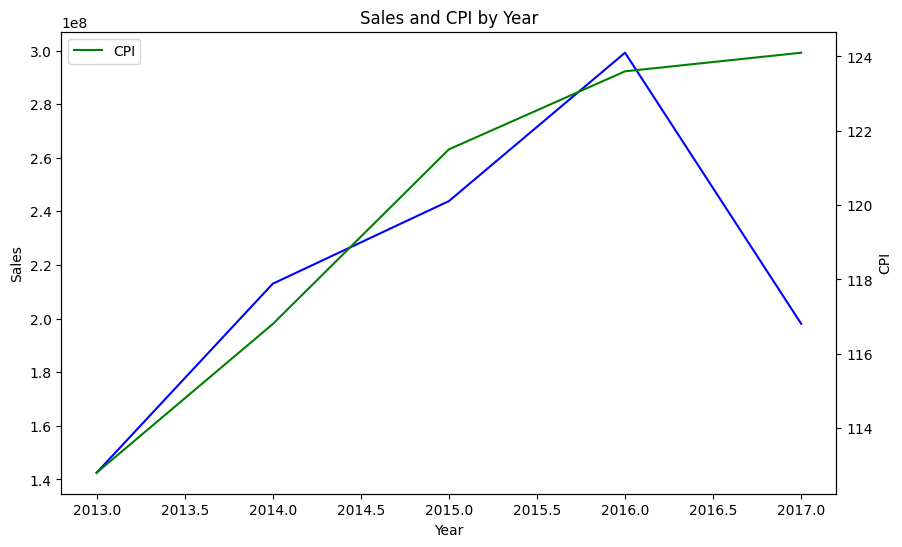

In [ ]:
# Group sales and Ecuador CPI by year
sales_by_year = total_df.groupby(total_df['date'].dt.year)['sales'].sum()
cpi_by_year = total_df.groupby(total_df['date'].dt.year)['ecuador_cpi'].mean()

# Plot sales by year
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year.index, sales_by_year.values, label='Sales', color='blue')
plt.xlabel('Year')
plt.ylabel('Sales')

# Create a second y-axis for CPI
plt.twinx()
plt.plot(cpi_by_year.index, cpi_by_year.values, label='CPI', color='green')
plt.ylabel('CPI')

# Add title and legend
plt.title('Sales and CPI by Year')
plt.legend()

plt.show()

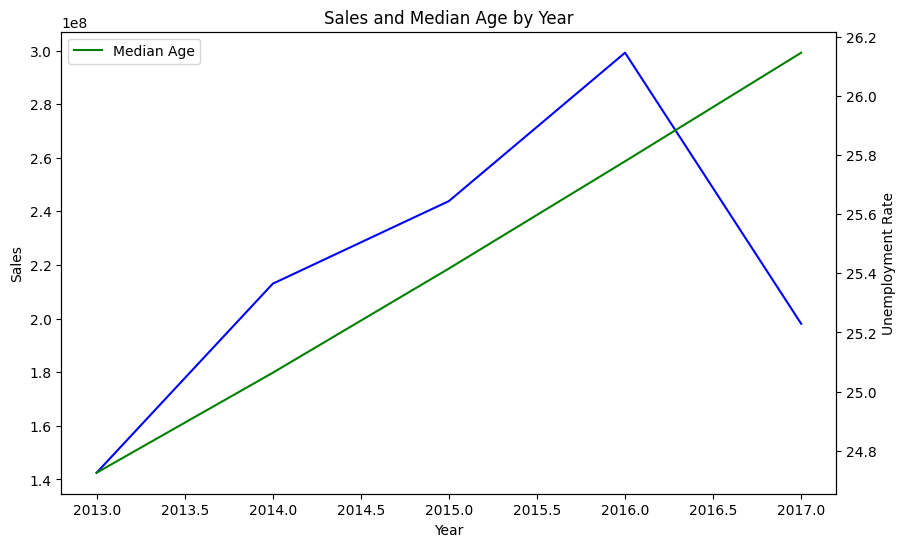

In [ ]:
# Group sales and Ecuador median age by year
sales_by_year = total_df.groupby(total_df['date'].dt.year)['sales'].sum()
median_age_by_year = total_df.groupby(total_df['date'].dt.year)['ecuador_median_age'].mean()

# Plot sales by year
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year.index, sales_by_year.values, label='Sales', color='blue')
plt.xlabel('Year')
plt.ylabel('Sales')

# Create a second y-axis for Median Age
plt.twinx()
plt.plot(median_age_by_year.index, median_age_by_year.values, label='Median Age', color='green')
plt.ylabel('Unemployment Rate')

# Add title and legend
plt.title('Sales and Median Age by Year')
plt.legend()

plt.show()

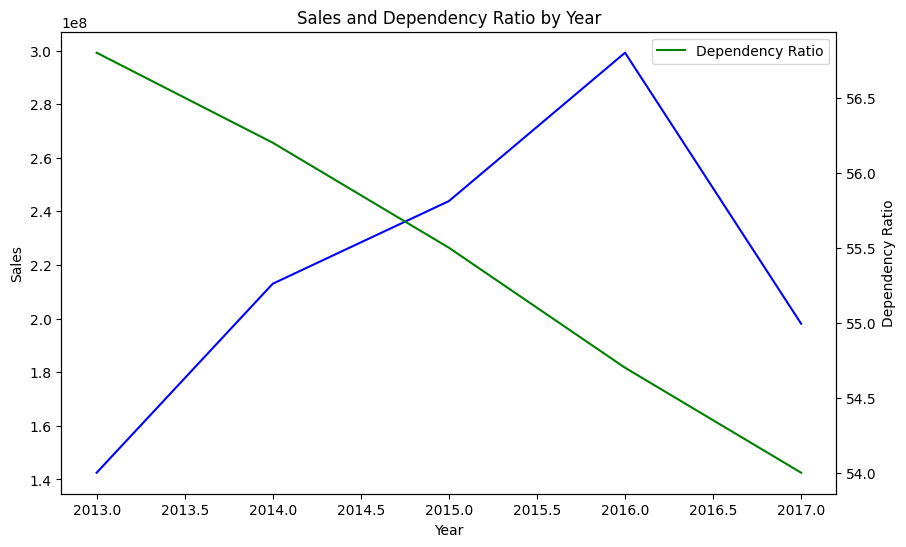

In [ ]:
# Group sales and Ecuador dependency ratio by year
sales_by_year = total_df.groupby(total_df['date'].dt.year)['sales'].sum()
dependency_ratio_by_year = total_df.groupby(total_df['date'].dt.year)['ecuador_dependency_ratio'].mean()

# Plot sales by year
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year.index, sales_by_year.values, label='Sales', color='blue')
plt.xlabel('Year')
plt.ylabel('Sales')

# Create a second y-axis for dependency ratio
plt.twinx()
plt.plot(dependency_ratio_by_year.index, dependency_ratio_by_year.values, label='Dependency Ratio', color='green')
plt.ylabel('Dependency Ratio')

# Add title and legend
plt.title('Sales and Dependency Ratio by Year')
plt.legend()

plt.show()

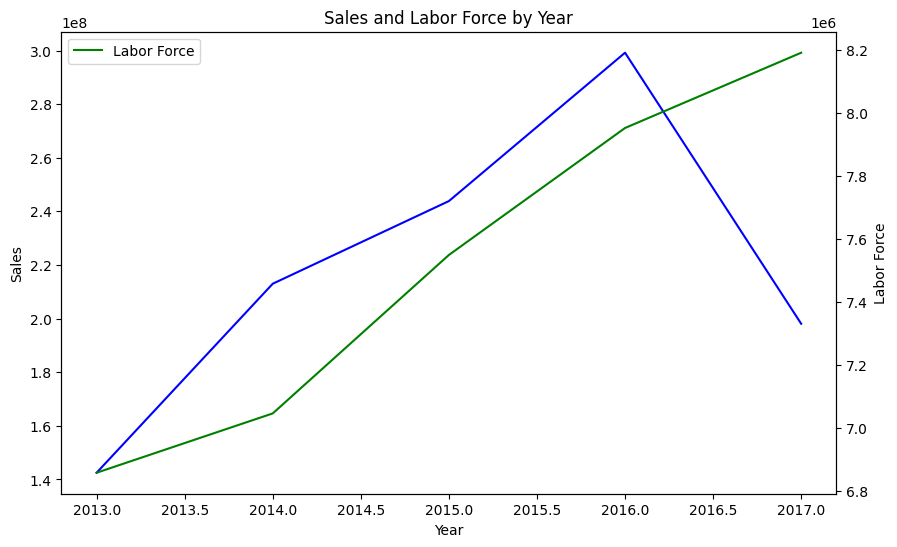

In [ ]:
# Group sales and labor force by year
sales_by_year = total_df.groupby(total_df['date'].dt.year)['sales'].sum()
labor_force_by_year = total_df.groupby(total_df['date'].dt.year)['ecuador_labor_force'].mean()

# Plot sales by year
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year.index, sales_by_year.values, label='Sales', color='blue')
plt.xlabel('Year')
plt.ylabel('Sales')

# Create a second y-axis for labor force
plt.twinx()
plt.plot(labor_force_by_year.index, labor_force_by_year.values, label='Labor Force', color='green')
plt.ylabel('Labor Force')

# Add title and legend
plt.title('Sales and Labor Force by Year')
plt.legend()

plt.show()

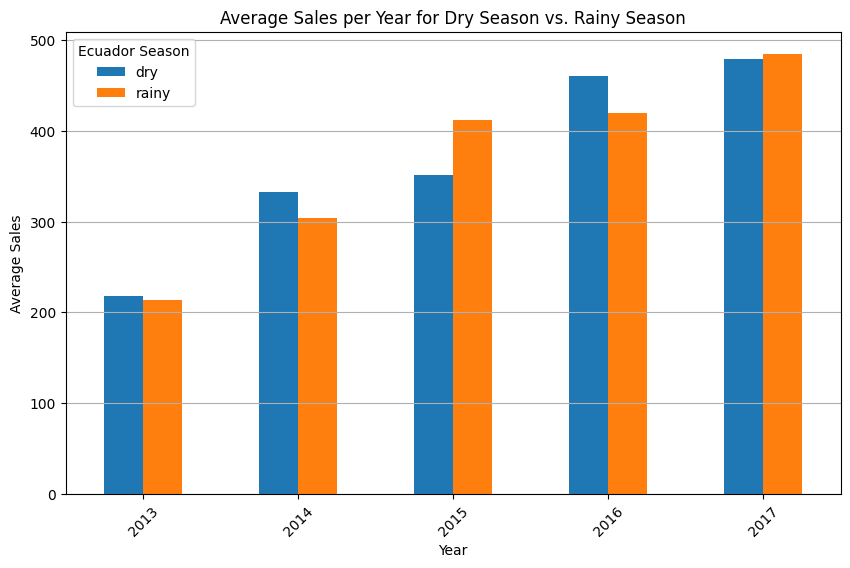

In [ ]:
# Group sales by year and 'ecuador_season', and calculate the average sales
sales_by_season = total_df.groupby([total_df['date'].dt.year, 'ecuador_season'])['sales'].mean().unstack()

# Plot average sales per year for dry season and rainy season
sales_by_season.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.title('Average Sales per Year for Dry Season vs. Rainy Season')
plt.legend(title='Ecuador Season')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

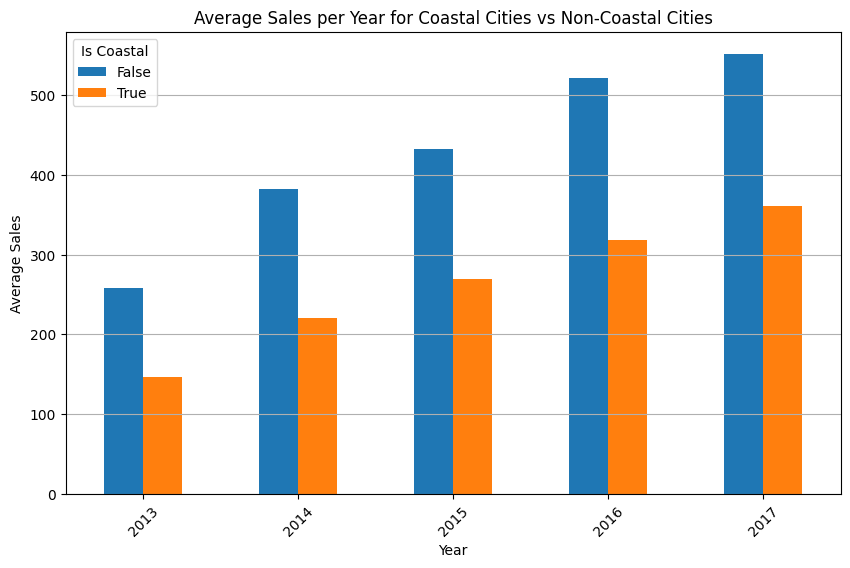

In [ ]:
# Group sales by year and is_coastal, calculate average sales
sales_by_coastal = total_df.groupby([total_df['date'].dt.year, 'is_coastal'])['sales'].mean().unstack()

# Plot average sales per year for coastal and non-coastal cities
sales_by_coastal.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.title('Average Sales per Year for Coastal Cities vs Non-Coastal Cities')
plt.legend(title='Is Coastal')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

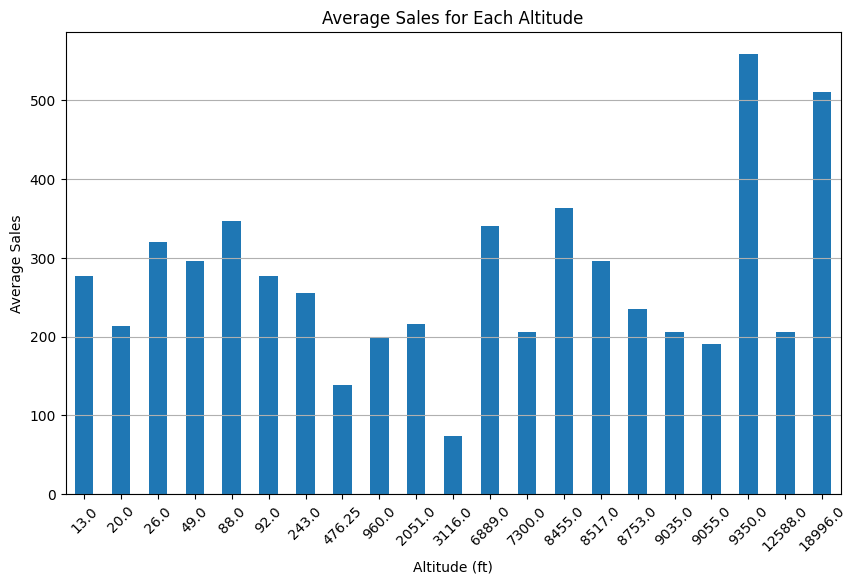

In [ ]:
# Group sales by city and calculate average sales
sales_by_city = total_df.groupby('city')['sales'].mean()

# Create a DataFrame to hold average sales and altitude for each city
city_sales_altitude_df = pd.DataFrame({'City': sales_by_city.index, 'Average Sales': sales_by_city.values})

# Add altitude data from the dictionary
city_sales_altitude_df['Altitude'] = city_sales_altitude_df['City'].map(altitude_data_ft)

# Sort cities by altitude in ascending order
city_sales_altitude_df.sort_values(by='Altitude', inplace=True)

# Group cities by altitude and calculate average sales
sales_by_altitude = city_sales_altitude_df.groupby('Altitude')['Average Sales'].mean()

# Plot average sales for each altitude
sales_by_altitude.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Altitude (ft)')
plt.ylabel('Average Sales')
plt.title('Average Sales for Each Altitude')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

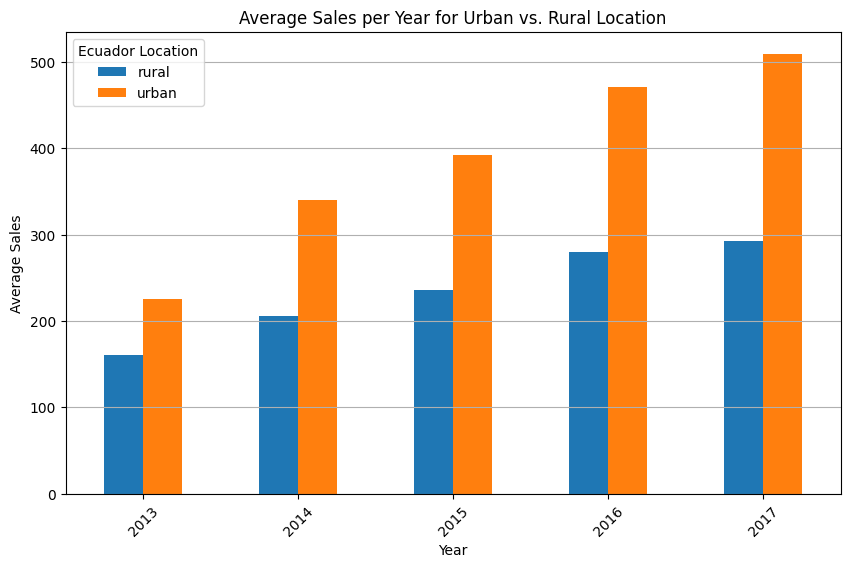

In [ ]:
# Group sales by year and location, and calculate the average sales
sales_by_location = total_df.groupby([total_df['date'].dt.year, 'location'])['sales'].mean().unstack()

# Plot average sales per year for urban/rural locations
sales_by_location.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.title('Average Sales per Year for Urban vs. Rural Location')
plt.legend(title='Ecuador Location')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

- Note: Data ends in August 2017, so data will be less then

Model Goals:
- Forecast Total Sales for Each Store for some future time frame
- Start with linear regression; then lasso, etc

Modeling:
- lasso regression + optimization
- ridge regression / randomforest


- NOTE: Sales spiked in 2016 due to earthquake, when people started to donate lots of food products, spiking their demand for these products from groceries.


- SIDE NOTE: Workers tend to be paid on 15th and last day of every month in public sector; which could spike sales around these times of the month

